# EEG feature plotting for different brain areas over time (across subjects)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import seaborn as sns
import matplotlib

import os
import random
import scipy

from bootstrap_code.bootstrap_routines import *
from utils import *
from eeg_feature_extraction.eeg_utils import *

# set random seed for reproducibility
random.seed(42)
sns.set_style("white")

In [2]:
duplicate_sents_data = pd.read_csv('./task_materials/duplicate_sentences.csv')
duplicate_sents = list(duplicate_sents_data.sentence.values)

In [3]:
electrodes_information = pd.read_csv('electrodes_information/105chanlocs.csv', sep=',')
eeg_electrodes_all = np.array(list(map(lambda val: val.strip("'"), electrodes_information.label.values)))

In [4]:
files_task2 = get_matfiles('task2')
files_task3 = get_matfiles('task3')

data_task2_sbj1 = io.loadmat(files_task2[0], squeeze_me=True, struct_as_record=False)['sentenceData']
data_task3_sbj1 = io.loadmat(files_task3[0], squeeze_me=True, struct_as_record=False)['sentenceData']

sent_lens_task2_sbj1 = [len(sent.word) for sent in data_task2_sbj1]
sent_lens_task3_sbj1 = [len(sent.word) for sent in data_task3_sbj1]

In [5]:
relation_labels_task2 = pd.read_csv('./task_materials/relations_labels_task2.csv', sep = ',')
relation_labels_task3 = pd.read_csv('./task_materials/relations_labels_task3.csv', sep = ';')

In [6]:
# get indices of sentences with relation labels
indices_relations_task2 = [idx for idx, relation in enumerate(relation_labels_task2.relation_types.values) if relation != 'NO-RELATION'] 
indices_no_relations_task2 = [idx for idx, relation in enumerate(relation_labels_task2.relation_types.values) if relation == 'NO-RELATION'] 
assert len(indices_relations_task2) + len(indices_no_relations_task2) == len(data_task2_sbj1)

indices_relations_task3 = [idx for idx, relation in enumerate(relation_labels_task3['relation-type'].values) if relation != 'CONTROL'] 
indices_no_relations_task3 = [idx for idx, relation in enumerate(relation_labels_task3['relation-type'].values) if relation == 'CONTROL'] 
assert len(indices_relations_task3) + len(indices_no_relations_task3) == len(data_task3_sbj1)

In [7]:
# Extract EEG features for all sentences for all tasks and subjects
eeg_feats_all_sbjs_task2_theta = eeg_freqs_across_sbj('task2', 'theta', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)
eeg_feats_all_sbjs_task3_theta = eeg_freqs_across_sbj('task3', 'theta', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)

In [8]:
# Extract EEG features for all sentences for all tasks and subjects
eeg_feats_all_sbjs_task2_alpha = eeg_freqs_across_sbj('task2', 'alpha', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)
eeg_feats_all_sbjs_task3_alpha = eeg_freqs_across_sbj('task3', 'alpha', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)

In [9]:
# Extract EEG features for all sentences for all tasks and subjects
eeg_feats_all_sbjs_task2_beta = eeg_freqs_across_sbj('task2', 'beta', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)
eeg_feats_all_sbjs_task3_beta = eeg_freqs_across_sbj('task3', 'beta', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)

In [10]:
# Extract EEG features for all sentences for all tasks and subjects
eeg_feats_all_sbjs_task2_gamma = eeg_freqs_across_sbj('task2', 'gamma', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)
eeg_feats_all_sbjs_task3_gamma = eeg_freqs_across_sbj('task3', 'gamma', merge='avg', et_feature='TRT', n_features='all', all_sbjs=False)

In [11]:
def compute_differences(eeg_feats_nr: np.ndarray, eeg_feats_tsr: np.ndarray, all_electrodes: np.ndarray):
    """
        Args:
            EEG feature matrix with all electrodes for a single frequency band (n_words x 105) - NR (np.array)
            EEG feature matrix with all electrodes for a single frequency band (n_words x 105) - TSR (np.array)
            NumPy array with electrode labels - necessary for mapping (np.array)
        Return:
            95% CI differences in electrode power spectra between the reading tasks sorded in descending order (np.array)
    """
    assert eeg_feats_nr.shape[1] == eeg_feats_tsr.shape[1]
    M = eeg_feats_nr.shape[1]
    tsr_indices, nr_indices  = [], []
    bootci_differences = np.zeros(M, dtype=float)
    for i in range(M):
        # compute bootstrapping per feature (i.e., electrode)
        ci_diff = bootci_diff(eeg_feats_nr[:, i], eeg_feats_tsr[:, i], nboot = 2000)
        p_val = bootpv(eeg_feats_nr[:, i], eeg_feats_tsr[:, i], nboot = 2000, printout=False)
        if ci_diff[0] < float(0) and p_val < 1e-2:
            tsr_indices.append(i)
        elif ci_diff[0] > float(0) and p_val < 1e-2:
            nr_indices.append(i)
        bootci_differences[i] += abs(ci_diff[0])
    # sort differences in electrode power spectra between the two reading tasks in descending order
    sorted_differences = np.argsort(bootci_differences)[::-1]
    return all_electrodes[sorted_differences], all_electrodes[tsr_indices], all_electrodes[nr_indices]

In [12]:
_, electrodes_tsr_theta, electrodes_nr_theta  = compute_differences(eeg_feats_all_sbjs_task2_theta, eeg_feats_all_sbjs_task3_theta, eeg_electrodes_all)

In [13]:
_, electrodes_tsr_alpha, electrodes_nr_alpha = compute_differences(eeg_feats_all_sbjs_task2_alpha, eeg_feats_all_sbjs_task3_alpha, eeg_electrodes_all)

In [14]:
_, electrodes_tsr_beta, electrodes_nr_beta = compute_differences(eeg_feats_all_sbjs_task2_beta, eeg_feats_all_sbjs_task3_beta, eeg_electrodes_all)

In [15]:
_, electrodes_tsr_gamma, electrodes_nr_gamma = compute_differences(eeg_feats_all_sbjs_task2_gamma, eeg_feats_all_sbjs_task3_gamma, eeg_electrodes_all)

In [16]:
# Extract EEG features for all sentences for all tasks and subjects
eeg_feats_all_sbjs_task2 = np.vstack([get_eeg_features('task2', i, 'most_important', 'avg') for i in range(12)])
eeg_feats_all_sbjs_task3 = np.vstack([get_eeg_features('task3', i, 'most_important', 'avg') for i in range(12)])

In [17]:
# Extract EEG features for duplicate sentences only
eeg_feats_all_sbjs_task2_dup = np.vstack([get_eeg_features('task2', i, 'most_important', 'avg', duplicate_sents=duplicate_sents) 
                                          for i in range(12)])
eeg_feats_all_sbjs_task3_dup = np.vstack([get_eeg_features('task3', i, 'most_important', 'avg', duplicate_sents=duplicate_sents) 
                                          for i in range(12)])

In [18]:
# Extract EEG features for sentences with or without relations respectively

eeg_feats_all_sbjs_task2_relations = np.vstack([get_eeg_features('task2', i, 'most_important', 'avg', 
                                                split_sents=True, relation_indices=indices_relations_task2) 
                                                for i in range(12)])

eeg_feats_all_sbjs_task2_no_relations = np.vstack([get_eeg_features('task2', i, 'most_important', 'avg',
                                                split_sents=True, relation_indices=indices_no_relations_task2) 
                                                for i in range(12)])

eeg_feats_all_sbjs_task3_relations = np.vstack([get_eeg_features('task3', i, 'most_important', 'avg', 
                                                split_sents=True, relation_indices=indices_relations_task3) 
                                                for i in range(12)])

eeg_feats_all_sbjs_task3_no_relations = np.vstack([get_eeg_features('task3', i, 'most_important', 'avg',
                                                split_sents=True, relation_indices=indices_no_relations_task3) 
                                                for i in range(12)])

In [19]:
eeg_data_per_sent_task2_sbj1 = reshape_into_tensor_vis(eeg_feats_all_sbjs_task2, sent_lens_task2_sbj1)
eeg_data_per_sent_task3_sbj1 = reshape_into_tensor_vis(eeg_feats_all_sbjs_task3, sent_lens_task3_sbj1)

In [20]:
eeg_data_per_sent_task2_sbj1_rel = reshape_into_tensor_vis(eeg_feats_all_sbjs_task2_relations, sent_lens_task2_sbj1)
eeg_data_per_sent_task2_sbj1_no_rel = reshape_into_tensor_vis(eeg_feats_all_sbjs_task2_no_relations, sent_lens_task2_sbj1)

eeg_data_per_sent_task3_sbj1_rel = reshape_into_tensor_vis(eeg_feats_all_sbjs_task3_relations, sent_lens_task3_sbj1)
eeg_data_per_sent_task3_sbj1_no_rel = reshape_into_tensor_vis(eeg_feats_all_sbjs_task3_no_relations, sent_lens_task3_sbj1)

In [21]:
eeg_locs_all_freqs = get_eeg_locs('\\important_eeg_features\\')
eeg_locs_alpha_freqs = eeg_locs_all_freqs[0]
eeg_locs_beta_freqs = eeg_locs_all_freqs[1]
eeg_locs_gamma_freqs = eeg_locs_all_freqs[2]
eeg_locs_theta_freqs = eeg_locs_all_freqs[3]

In [22]:
# important variables for plotting and statistical analyses
temporal_electrodes_alpha = ['E38', 'E43', 'E120', 'E121']
temporal_electrodes_beta = ['E38', 'E43', 'E57', 'E121']
temporal_electrodes_gamma = ['E38', 'E43', 'E44', 'E121']
temporal_electrodes_theta = ['E38', 'E43', 'E114', 'E120', 'E121']

frontoparietal_electrodes_alpha = ['E26', 'E30', 'E54']
frontoparietal_electrodes_beta = ['E2', 'E12', 'E26', 'E30' ]
frontoparietal_electrodes_gamma = ['E2', 'E26', 'E31']
frontoparietal_electrodes_theta = ['E4', 'E5', 'E118']

et_feature = 'TRT'

## $\alpha$-frequency domain

In [23]:
## Temporal Cortex ##
temporal_electrodes_alpha_all, temporal_indices_alpha_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                           eeg_locs_alpha_freqs, 
                                                                                           temporal_electrodes_alpha)
## Frontal & Parietal Cortex ##
frontoparietal_electrodes_alpha_all, frontoparietal_indices_alpha_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                                       eeg_locs_alpha_freqs, 
                                                                                                       frontoparietal_electrodes_alpha)

In [24]:
#kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

#feat = 0
#fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
#for i, row in enumerate(axes):
#    for j, col in enumerate(row):
#        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_alpha_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_alpha_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.6))
#        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.5))
#        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_features[i]), fontsize = 10)
#        axes[i][j].set_ylabel(r'Density')
#        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
#        axes[i][j].set_xlim(0, 2.5)
#        feat += 1
#plt.savefig('plots/alpha_activity_temporal')
#plt.show()

In [25]:
# set number of bootstrapping experiments to 1000 (laptop will crash with 10000 experiments)
n_boot_exp = 1000

### Density plots for activity in temporal cortex for duplicate sentences across all tasks and subjects

Observed difference of two means: -0.12
0 out of 1000 experiments had a difference of two means less than or equal to -0.12
The chance of getting a difference of two means less than or equal to -0.12 is 0.0000
Observed difference of two means: -0.08
0 out of 1000 experiments had a difference of two means less than or equal to -0.08
The chance of getting a difference of two means less than or equal to -0.08 is 0.0000
Observed difference of two means: -0.01
312 out of 1000 experiments had a difference of two means less than or equal to -0.01
The chance of getting a difference of two means less than or equal to -0.01 is 0.3120
Observed difference of two means: 0.02
21 out of 1000 experiments had a difference of two means greater than or equal to 0.02
The chance of getting a difference of two means greater than or equal to 0.02 is 0.0210


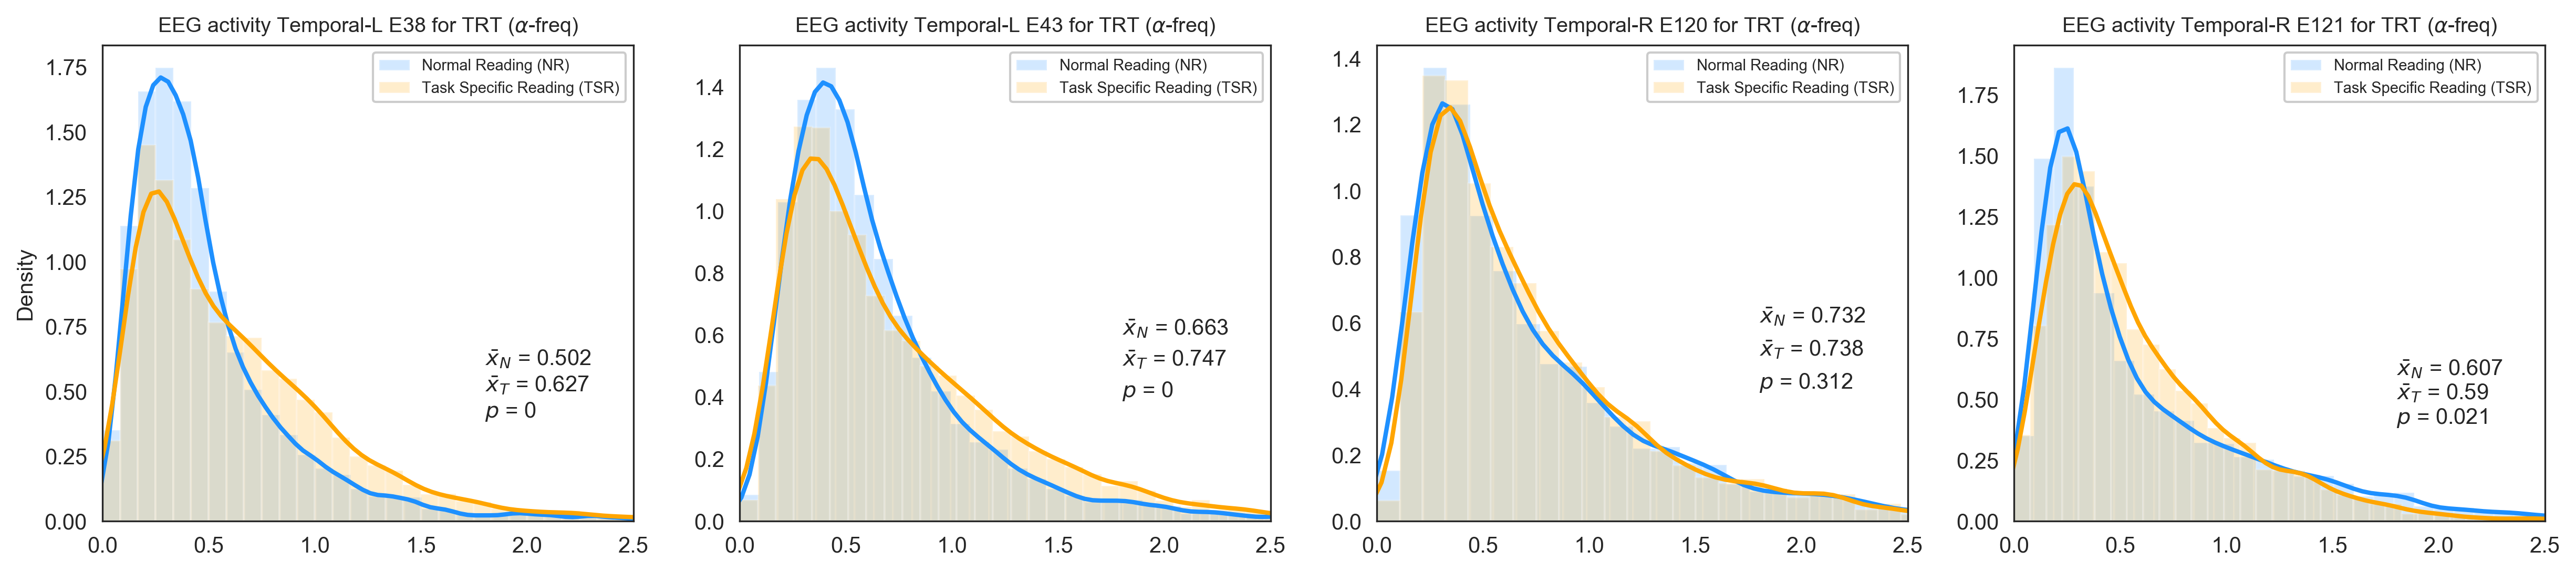

<Figure size 432x288 with 0 Axes>

In [26]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_dup[:, temporal_indices_alpha_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_dup[:, temporal_indices_alpha_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    axes[i].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2_dup[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.6))
    axes[i].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3_dup[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.5))
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2_dup[:, temporal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_dup[:, temporal_indices_alpha_all[feat]], nboot=1000)), (1.8, 0.4))
    if i < 2:
        axes[i].set_title(r'EEG activity Temporal-L {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    else:
        axes[i].set_title(r'EEG activity Temporal-R {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in temporal cortex for all sentences across all tasks and subjects

Observed difference of two means: 0.01
36 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.0360
Observed difference of two means: 0.01
150 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.1500
Observed difference of two means: 0.01
31 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.0310
Observed difference of two means: 0.00
311 out of 1000 experiments had a difference of two means greater than or equal to 0.00
The chance of getting a difference of two means greater than or equal to 0.00 is 0.3110
Observed difference of two means: 0.00
450 out of 1000 experiments had a difference of two means greater than or equal to 0.00
The chance of g

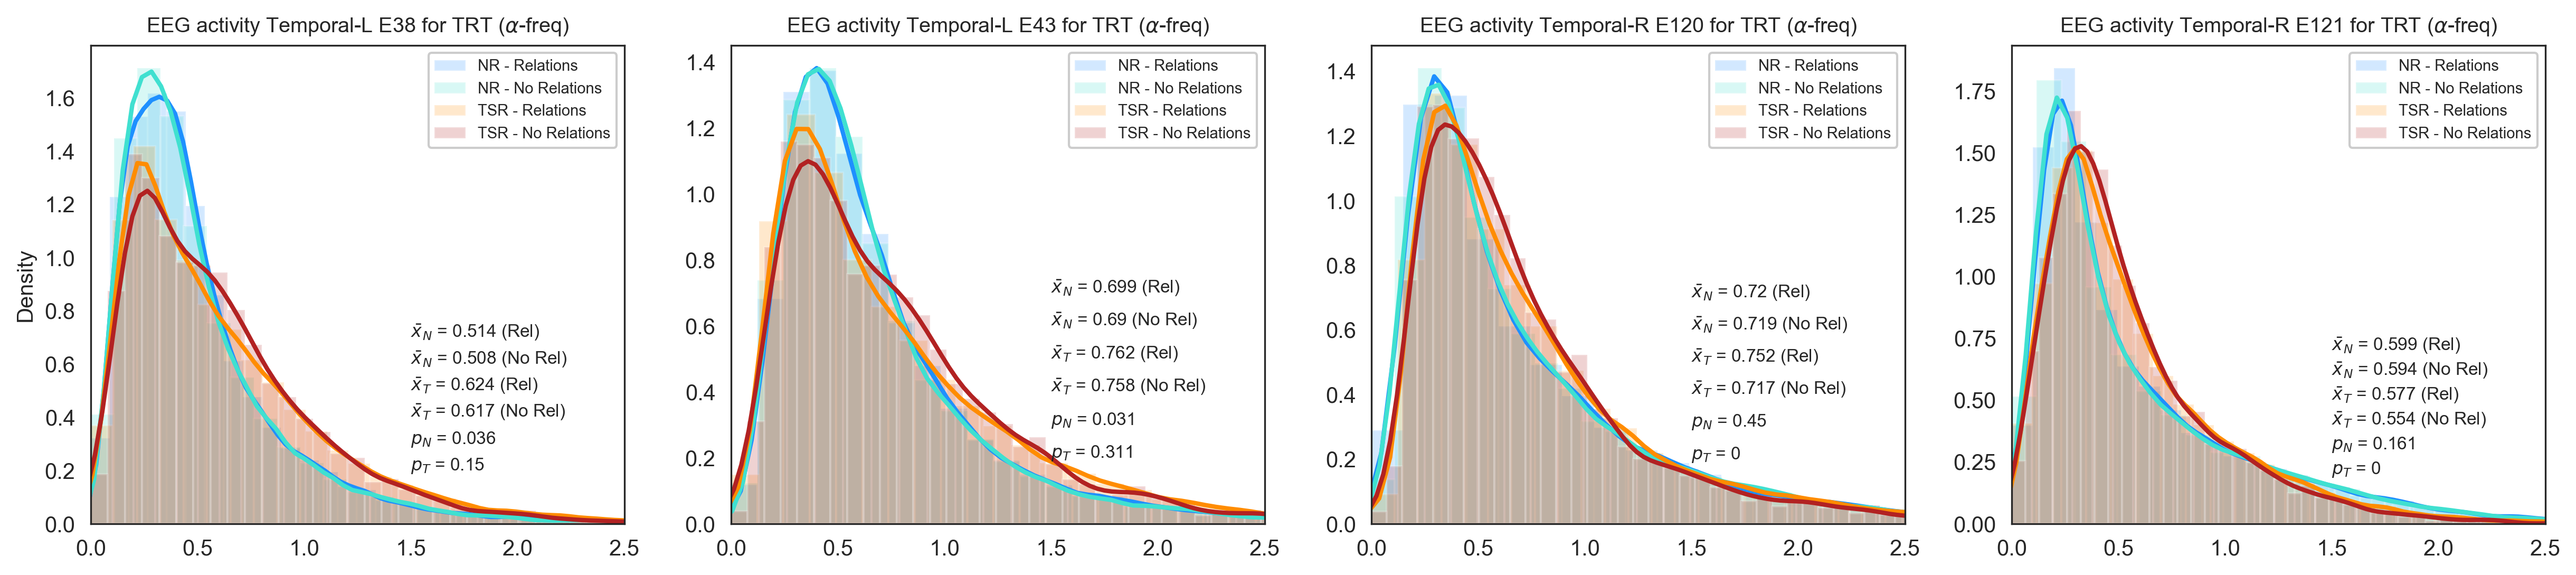

<Figure size 432x288 with 0 Axes>

In [27]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_alpha_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_alpha_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_alpha_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_alpha_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_alpha_all[feat]].mean()), (1.5, 0.7), fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_alpha_all[feat]].mean()), (1.5, 0.6), fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_alpha_all[feat]].mean()), (1.5, 0.5), fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_alpha_all[feat]].mean()), (1.5, 0.4), fontsize=8)
    axes[i].annotate(r'$p_N$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_alpha_all[feat]], nboot=1000)), (1.5, 0.3), fontsize=8)
    axes[i].annotate(r'$p_T$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_alpha_all[feat]], nboot=1000)), (1.5, 0.2), fontsize=8)
    if i < 2:
        axes[i].set_title(r'EEG activity Temporal-L {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    else:
        axes[i].set_title(r'EEG activity Temporal-R {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in frontoparietal cortex for duplicate sentences across all tasks and subjects

Observed difference of two means: -0.07
0 out of 1000 experiments had a difference of two means less than or equal to -0.07
The chance of getting a difference of two means less than or equal to -0.07 is 0.0000
Observed difference of two means: 0.01
119 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.1190
Observed difference of two means: 0.26
0 out of 1000 experiments had a difference of two means greater than or equal to 0.26
The chance of getting a difference of two means greater than or equal to 0.26 is 0.0000


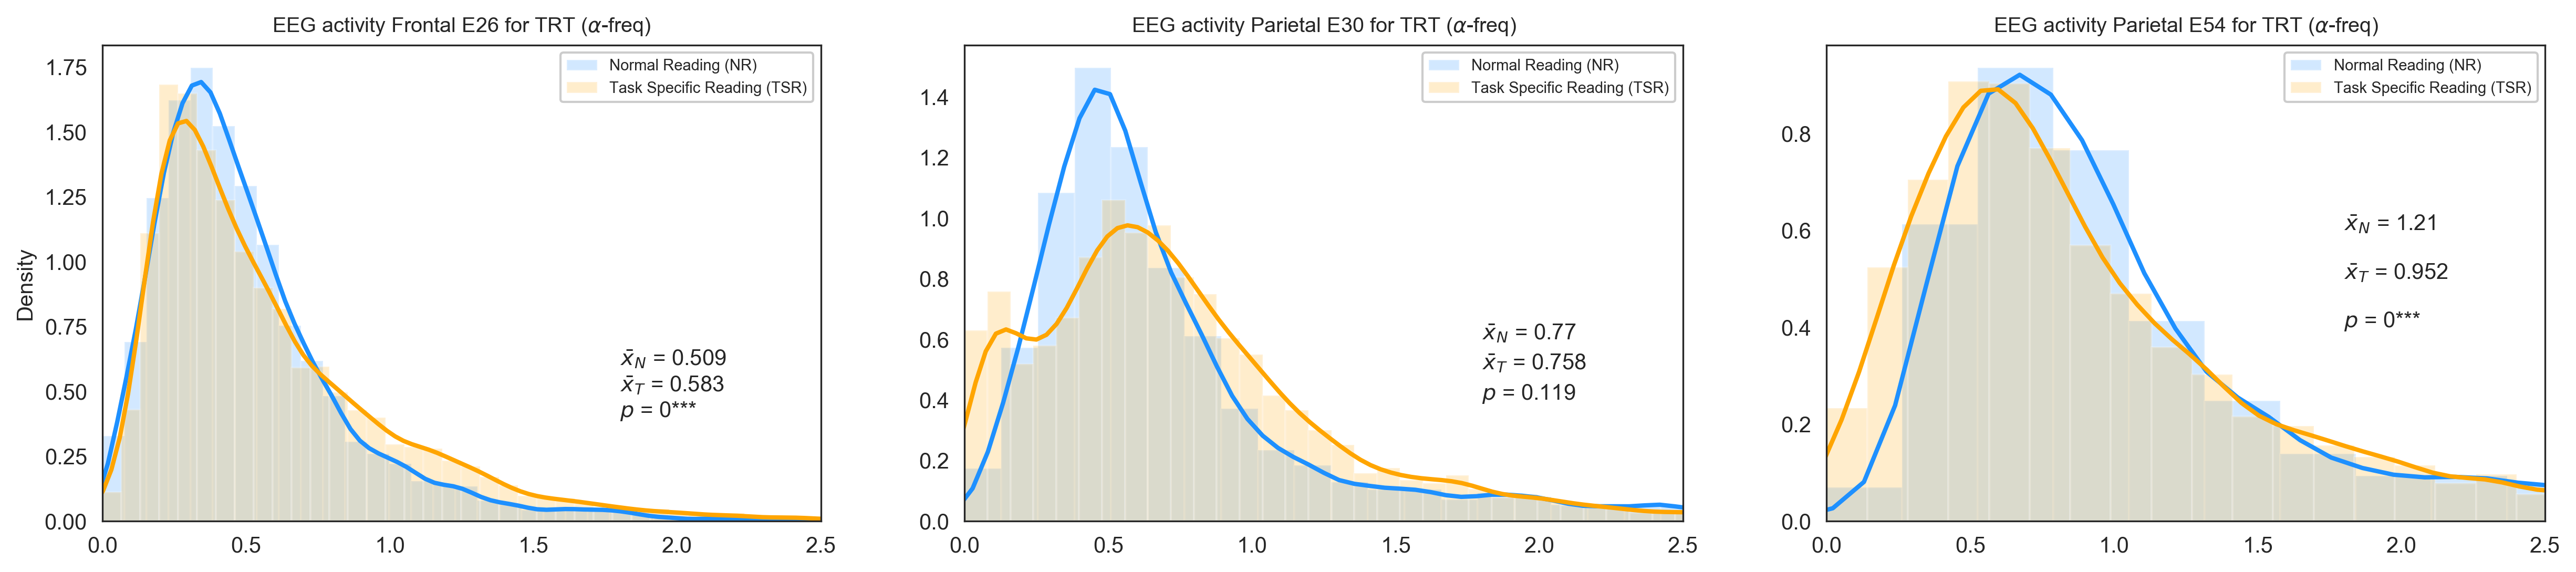

<Figure size 432x288 with 0 Axes>

In [28]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_dup[:, frontoparietal_indices_alpha_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_dup[:, frontoparietal_indices_alpha_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    axes[i].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2_dup[:, frontoparietal_indices_alpha_all[feat]].mean()), (1.8, 0.6))
    axes[i].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3_dup[:, frontoparietal_indices_alpha_all[feat]].mean()), (1.8, 0.5))
    if i == 1:
        axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2_dup[:, frontoparietal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_dup[:, frontoparietal_indices_alpha_all[feat]], nboot=1000)), (1.8, 0.4))
    else:
        axes[i].annotate(r'$p$ = {:.3g}***'.format(bootpv(eeg_feats_all_sbjs_task2_dup[:, frontoparietal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_dup[:, frontoparietal_indices_alpha_all[feat]], nboot=1000)), (1.8, 0.4))
    if i == 0:
        axes[i].set_title(r'EEG activity Frontal {} for {} ($\alpha$-freq)'.format(frontoparietal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    else:
        axes[i].set_title(r'EEG activity Parietal {} for {} ($\alpha$-freq)'.format(frontoparietal_electrodes_alpha_all[feat], et_feature), fontsize=9.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in frontoparietal cortex for all sentences across all tasks and subjects

Observed difference of two means: 0.00
266 out of 1000 experiments had a difference of two means greater than or equal to 0.00
The chance of getting a difference of two means greater than or equal to 0.00 is 0.2660
Observed difference of two means: 0.01
171 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.1710
Observed difference of two means: 0.00
439 out of 1000 experiments had a difference of two means greater than or equal to 0.00
The chance of getting a difference of two means greater than or equal to 0.00 is 0.4390
Observed difference of two means: -0.02
4 out of 1000 experiments had a difference of two means less than or equal to -0.02
The chance of getting a difference of two means less than or equal to -0.02 is 0.0040
Observed difference of two means: 0.01
130 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of gett

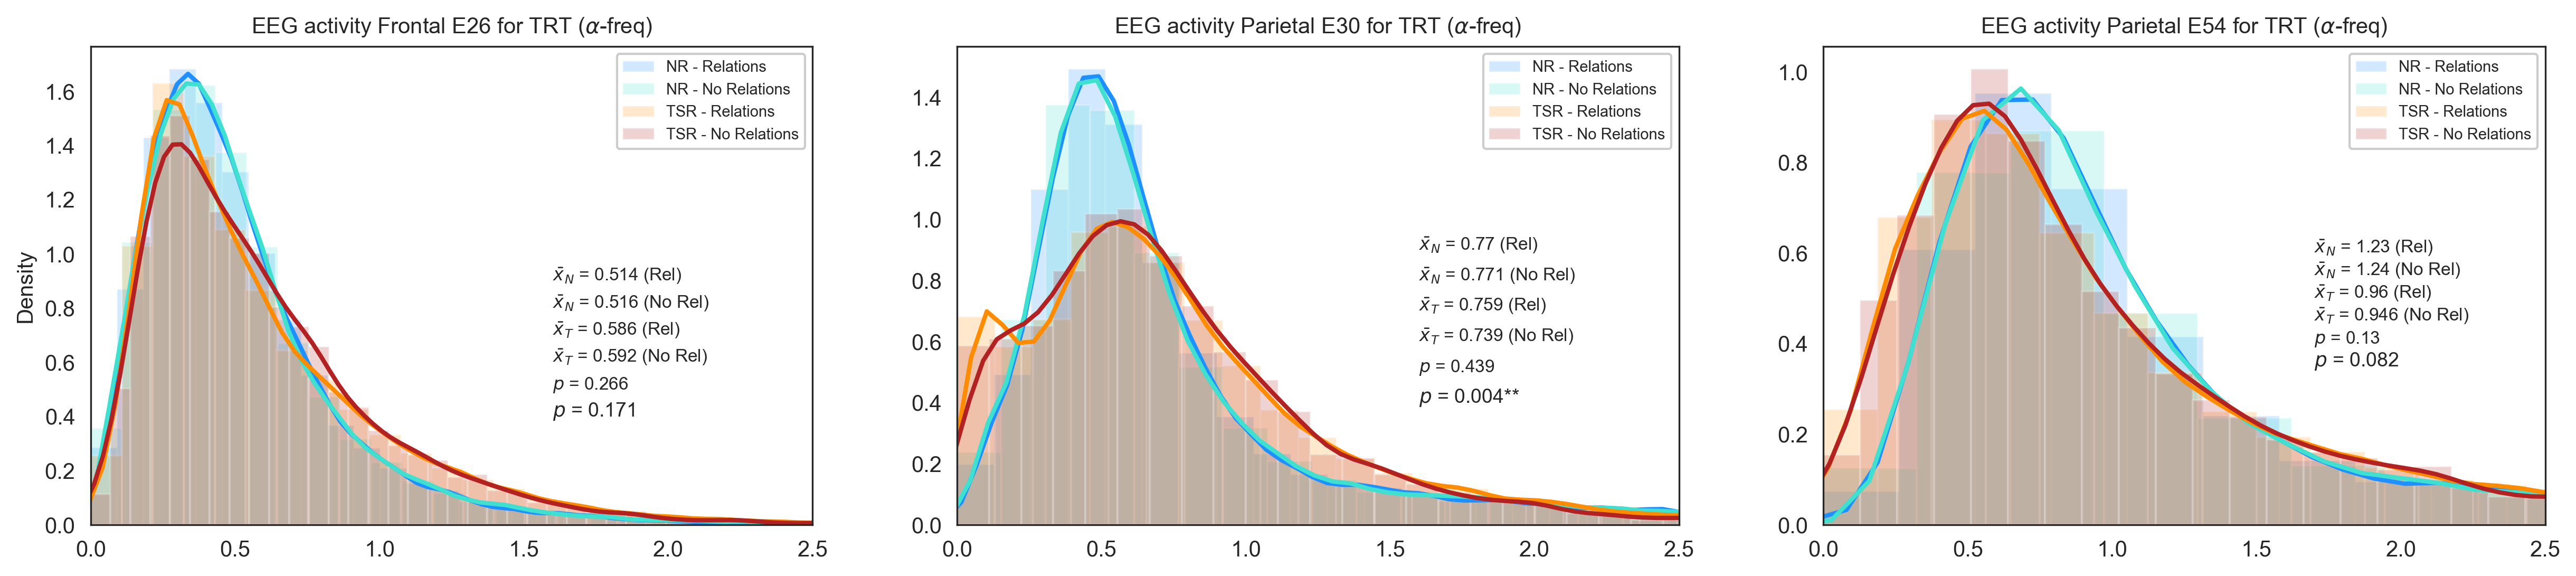

<Figure size 432x288 with 0 Axes>

In [29]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_alpha_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_alpha_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_alpha_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_alpha_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    xy_pos = [(1.7, 0.6), (1.7, 0.55), (1.7, 0.5), (1.7, 0.45)] if i == 2 else [(1.6, 0.9), (1.6, 0.8), (1.6, 0.7), (1.6, 0.6)]
    xy_pos_text = ((1.7, 0.40), (1.7, 0.35))  if i == 2 else ((1.6, 0.5), (1.6, 0.4)) 
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_alpha_all[feat]].mean()), xy_pos[0], fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_alpha_all[feat]].mean()), xy_pos[1], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_alpha_all[feat]].mean()), xy_pos[2], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_alpha_all[feat]].mean()), xy_pos[3], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_alpha_all[feat]], nboot=1000)), xy_pos_text[0], fontsize=8)
    if i == 1: 
        axes[i].annotate(r'$p$ = {:.3g}**'.format(bootpv(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_alpha_all[feat]], nboot=1000)), xy_pos_text[1], fontsize=9)
    else:
        axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_alpha_all[feat]], eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_alpha_all[feat]], nboot=1000)), xy_pos_text[1], fontsize=9)
    if i == 0:
        axes[i].set_title(r'EEG activity Frontal {} for {} ($\alpha$-freq)'.format(frontoparietal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
    else:
        axes[i].set_title(r'EEG activity Parietal {} for {} ($\alpha$-freq)'.format(frontoparietal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Brain activity in the temporal cortex over time for single test subject(s) (Normal Reading)

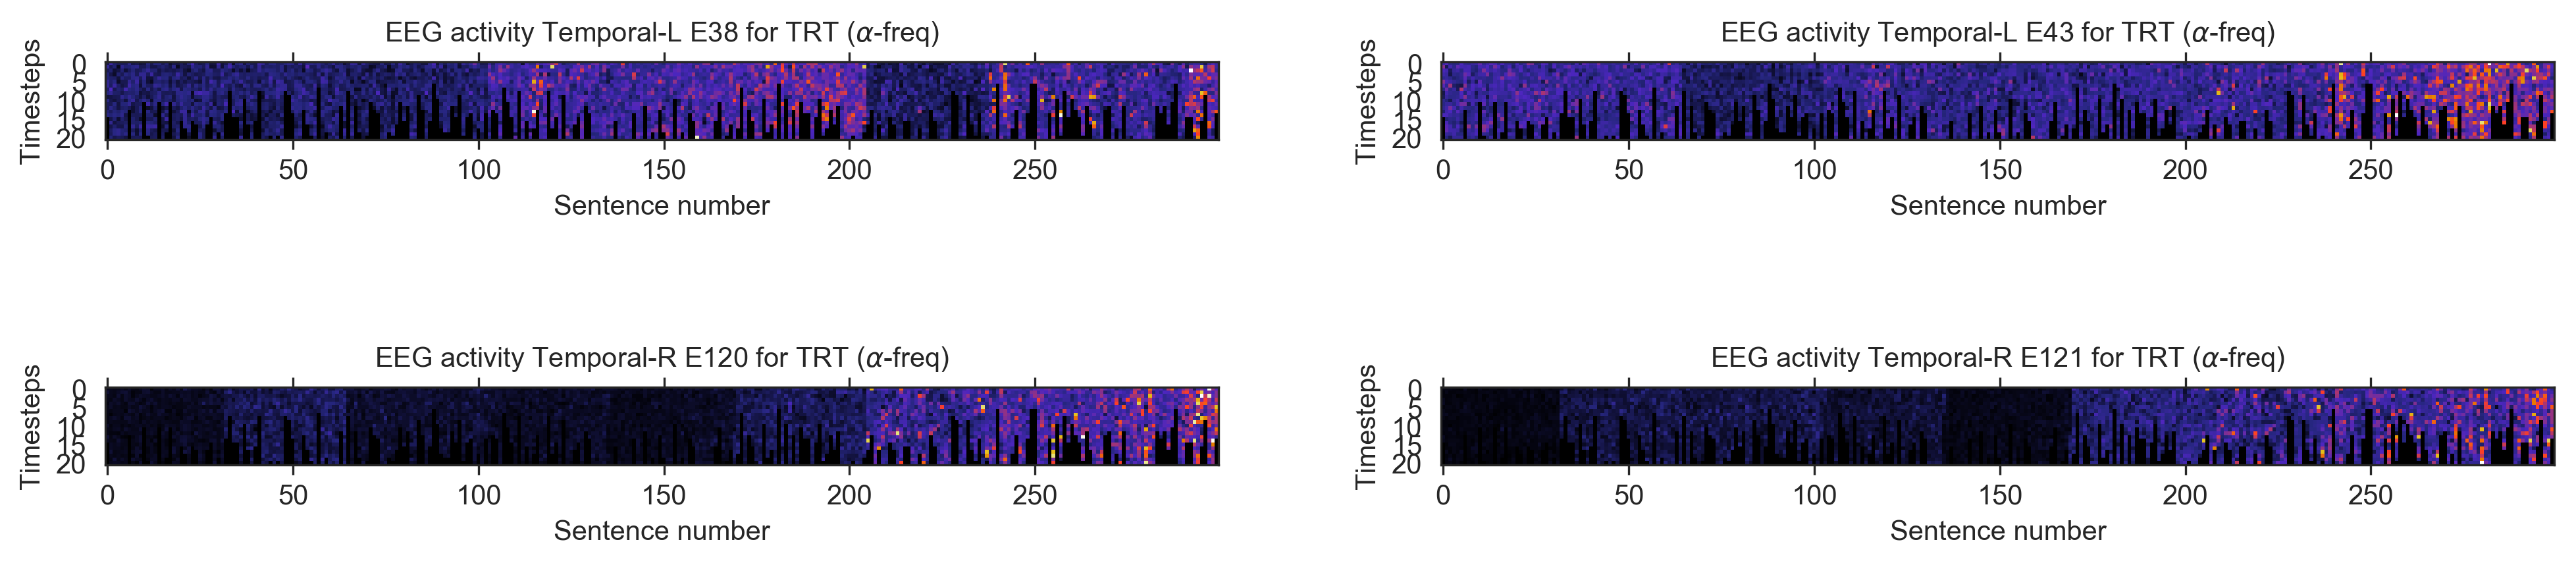

In [39]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(16, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_alpha_all[feat])).T, cmap='CMRmap')
        if (i % 2 == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/alpha_activity_temporal_heatmap_sbj1_task2')
plt.show()

### Brain activity in the temporal cortex over time for single test subject(s) (Task Specific Reading)

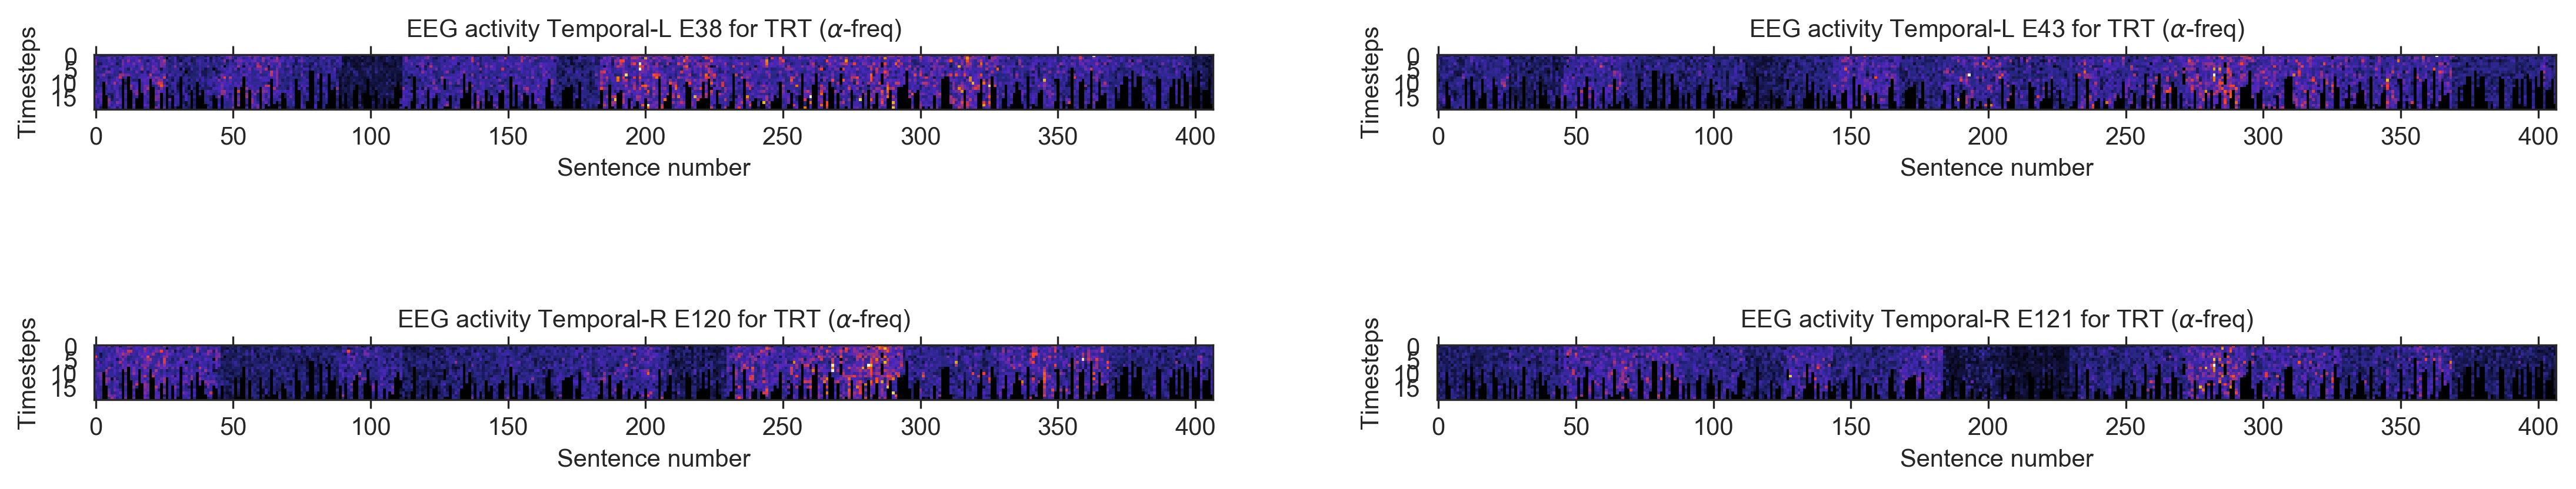

<Figure size 432x288 with 0 Axes>

In [27]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_alpha_all[feat])).T, cmap='CMRmap')
        if (i % 2 == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/alpha_activity_temporal_heatmap_sbj1_task3')
plt.show()
plt.clf()

## $\beta$-frequency domain

In [47]:
## Temporal Cortex ##
temporal_electrodes_beta_all, temporal_indices_beta_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                         eeg_locs_beta_freqs, 
                                                                                         temporal_electrodes_beta, 
                                                                                         k=10)
## Frontal & Parietal Cortex ##
frontoparietal_electrodes_beta_all, frontoparietal_indices_beta_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                                     eeg_locs_beta_freqs, 
                                                                                                     frontoparietal_electrodes_beta, 
                                                                                                     k=10)

In [ ]:
#kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

#feat = 0
#fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
#for i, row in enumerate(axes):
#    for j, col in enumerate(row):
#        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_beta_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_beta_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_beta_all[feat]].mean()), (1.8, 0.6))
#        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_beta_all[feat]].mean()), (1.8, 0.45))
#        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_features[i]), fontsize = 10)
#        axes[i][j].set_ylabel(r'Density')
#        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
#        axes[i][j].set_xlim(0, 2.5)
#        feat += 1
#plt.savefig('plots/beta_activity_temporal')
#plt.show()

### Density plots for activity in temporal cortex across all tasks and subjects

Observed difference of two means: -0.17
0 out of 1000 experiments had a difference of two means less than or equal to -0.17
The chance of getting a difference of two means less than or equal to -0.17 is 0.0000
Observed difference of two means: -0.13
0 out of 1000 experiments had a difference of two means less than or equal to -0.13
The chance of getting a difference of two means less than or equal to -0.13 is 0.0000
Observed difference of two means: 0.10
0 out of 1000 experiments had a difference of two means greater than or equal to 0.10
The chance of getting a difference of two means greater than or equal to 0.10 is 0.0000
Observed difference of two means: -0.00
98 out of 1000 experiments had a difference of two means less than or equal to -0.00
The chance of getting a difference of two means less than or equal to -0.00 is 0.0980


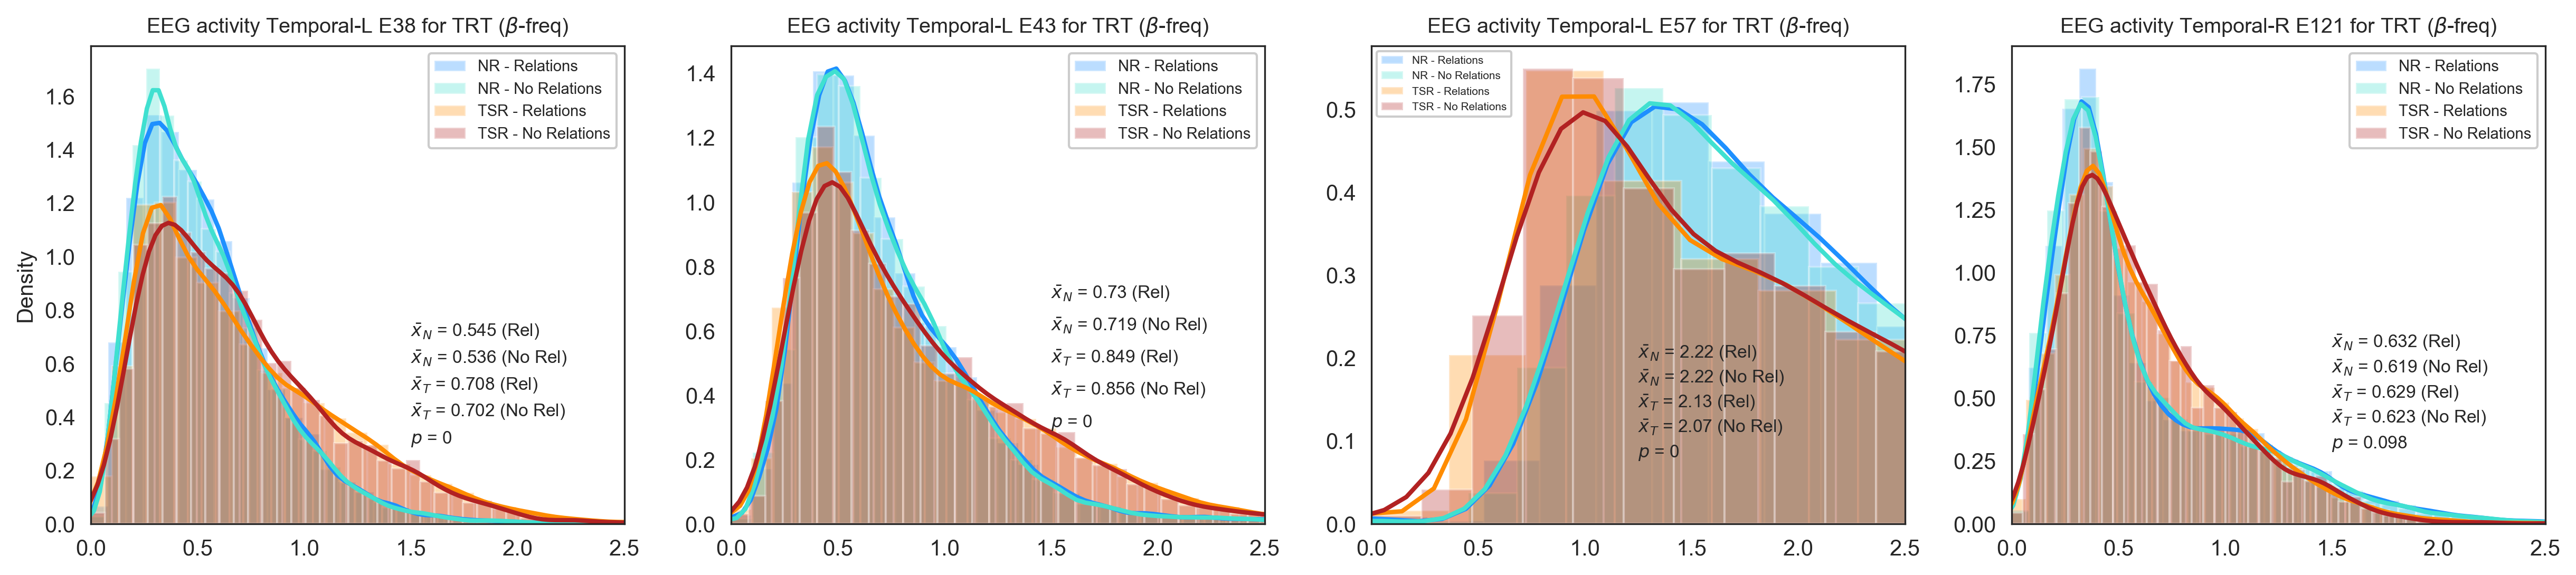

<Figure size 432x288 with 0 Axes>

In [48]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_beta_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_beta_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_beta_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_beta_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    xy_pos = [(1.25, 0.2), (1.25, 0.17), (1.25, 0.14), (1.25, 0.11)] if i == 2 else [(1.5, 0.7), (1.5, 0.6), (1.5, 0.5), (1.5, 0.4)]
    xy_pos_text = (1.25, 0.08) if i == 2 else (1.5, 0.3)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_beta_all[feat]].mean()), xy_pos[0], fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_beta_all[feat]].mean()), xy_pos[1], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_beta_all[feat]].mean()), xy_pos[2], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_beta_all[feat]].mean()), xy_pos[3], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2[:, temporal_indices_beta_all[feat]], eeg_feats_all_sbjs_task3[:, temporal_indices_beta_all[feat]], nboot=1000)), xy_pos_text, fontsize=8)
    if i < 3:
        axes[i].set_title(r'EEG activity Temporal-L {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize=9.5)
    else:
        axes[i].set_title(r'EEG activity Temporal-R {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize=9.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    loc = 'upper left' if i == 2 else 'upper right'
    size = {'size': 5} if i == 2 else {'size': 7}
    axes[i].legend(fancybox=True, framealpha=1, loc=loc, prop=size)
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in frontoparietal cortex across all tasks and subjects

Observed difference of two means: 0.01
196 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.1960
Observed difference of two means: 0.01
53 out of 1000 experiments had a difference of two means greater than or equal to 0.01
The chance of getting a difference of two means greater than or equal to 0.01 is 0.0530


NameError: name 'j' is not defined

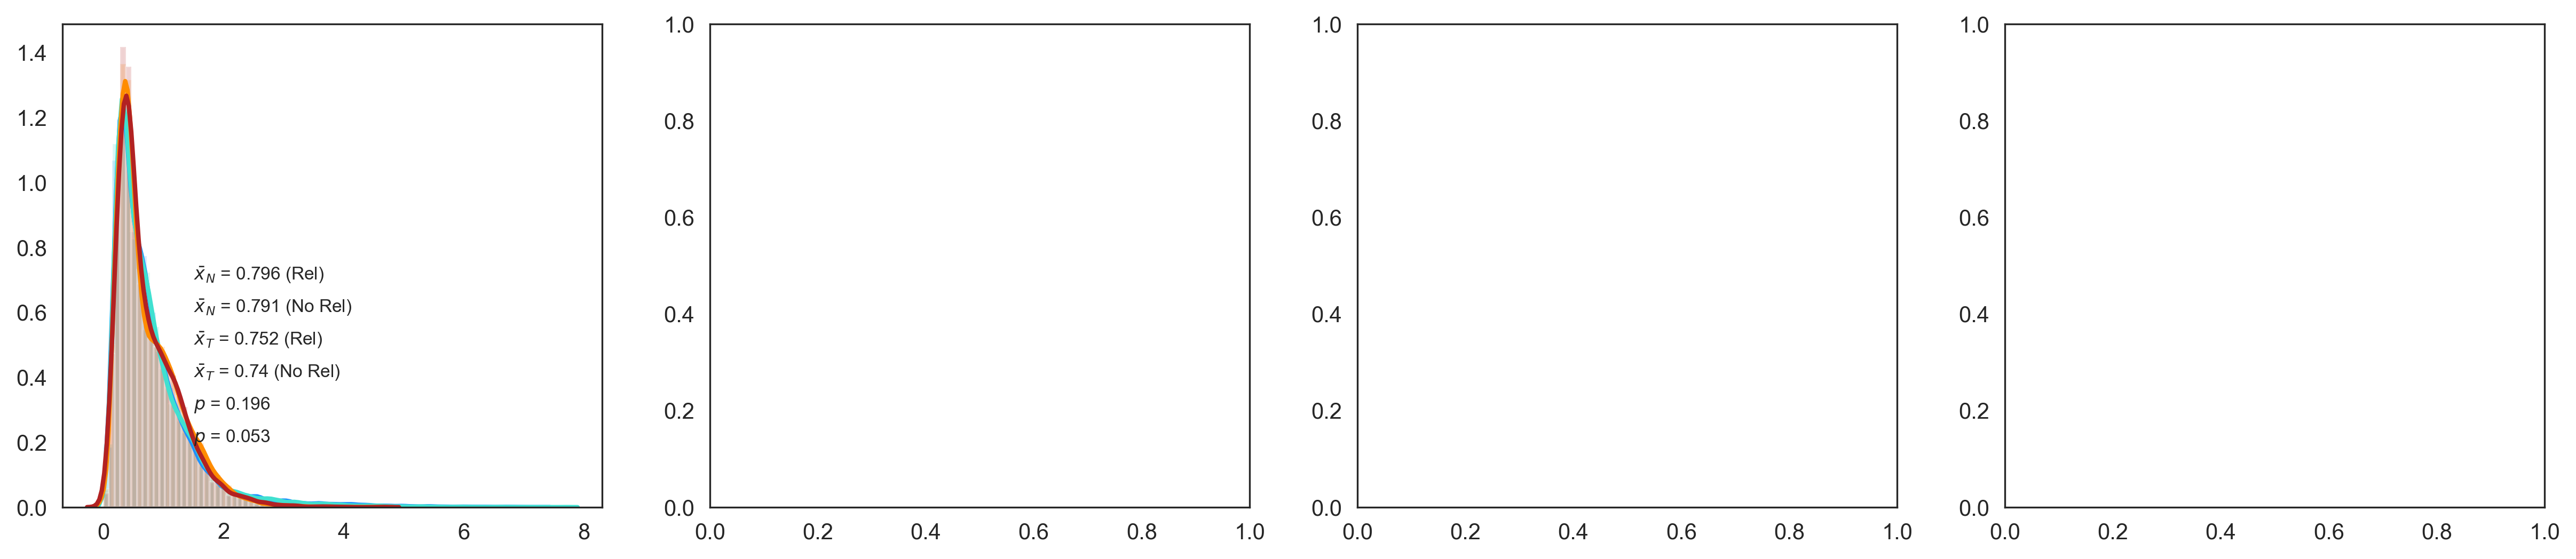

In [49]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_beta_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_beta_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_beta_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_beta_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    pos = [(1.5, 0.6), (1.5, 0.55), (1.5, 0.5), (1.5, 0.45)] if i == 1 else [(1.5, 0.7), (1.5, 0.6), (1.5, 0.5), (1.5, 0.4)]
    xy_pos_text = ((1.5, 0.4), (1.5, 0.35)) if i == 1 else ((1.5, 0.3), (1.5, 0.2)) 
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_beta_all[feat]].mean()), pos[0], fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_beta_all[feat]].mean()), pos[1], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_beta_all[feat]].mean()), pos[2], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_beta_all[feat]].mean()), pos[3], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_beta_all[feat]], eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_beta_all[feat]], nboot=1000)), xy_pos_text[0], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_beta_all[feat]], eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_beta_all[feat]], nboot=1000)), xy_pos_text[1], fontsize=8)
    if j == 0 or j == 2:
        axes[i].set_title(r'EEG activity Frontal {} for {} ($\beta$-freq)'.format(frontoparietal_electrodes_beta_all[feat], et_feature), fontsize = 10)
    else:
        axes[i].set_title(r'EEG activity Parietal {} for {} ($\beta$-freq)'.format(frontoparietal_electrodes_beta_all[feat], et_feature), fontsize = 10)
    if j == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Brain activity in the temporal cortex over time for single test subject(s) (Normal Reading)

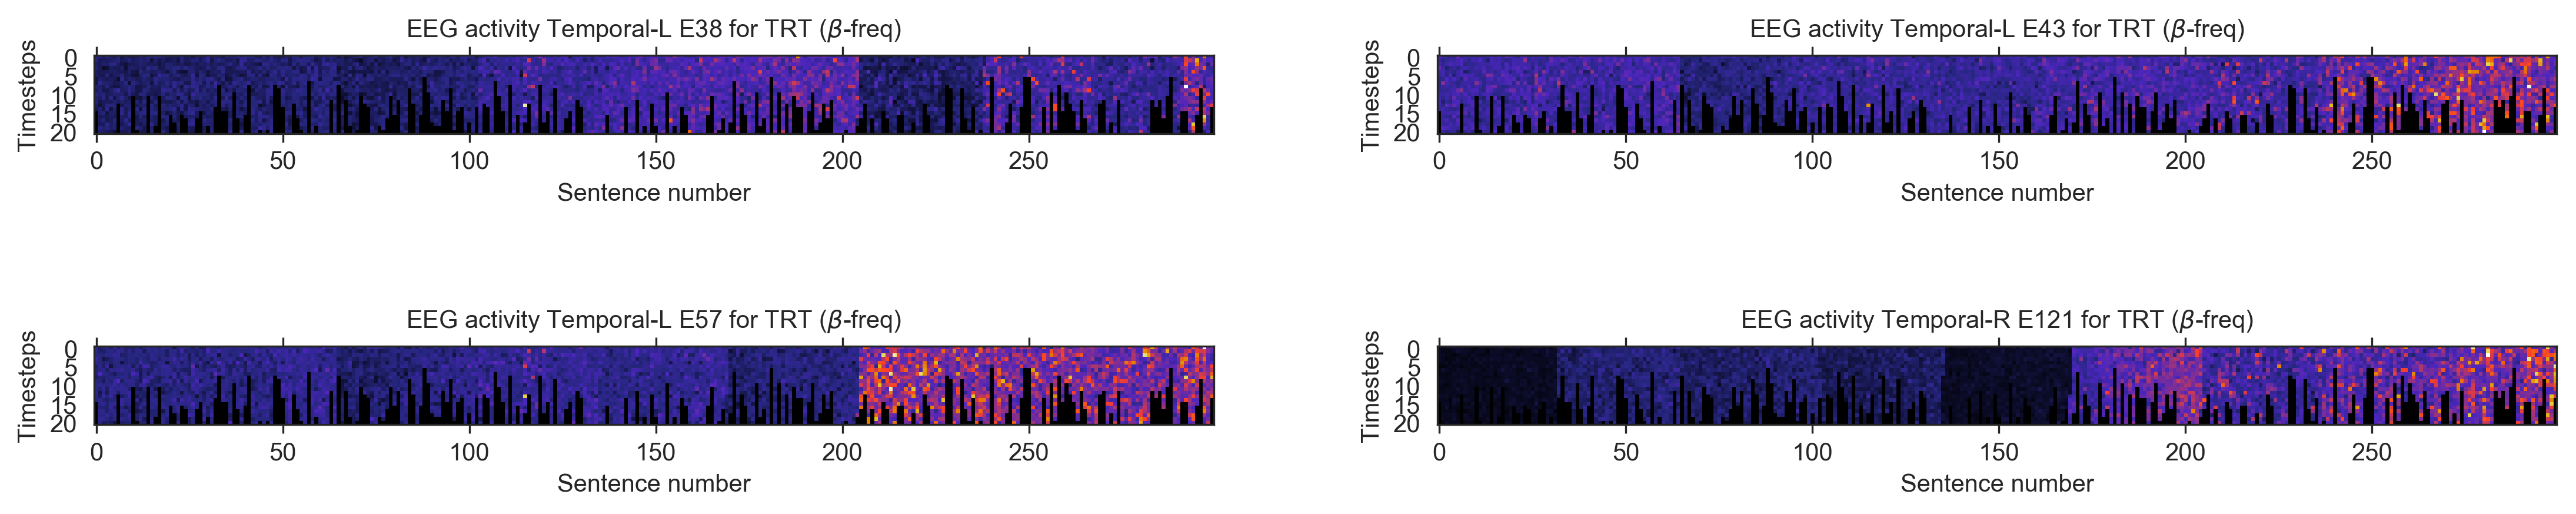

<Figure size 432x288 with 0 Axes>

In [37]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_beta_all[feat])).T, cmap='CMRmap')
        if (i % 2 == 0) or (i % 2 != 0 and j == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/beta_activity_temporal_heatmap_sbj1_task2')
plt.show()
plt.clf()

### Brain activity in the temporal cortex over time for single test subject(s) (Task Specific Reading)

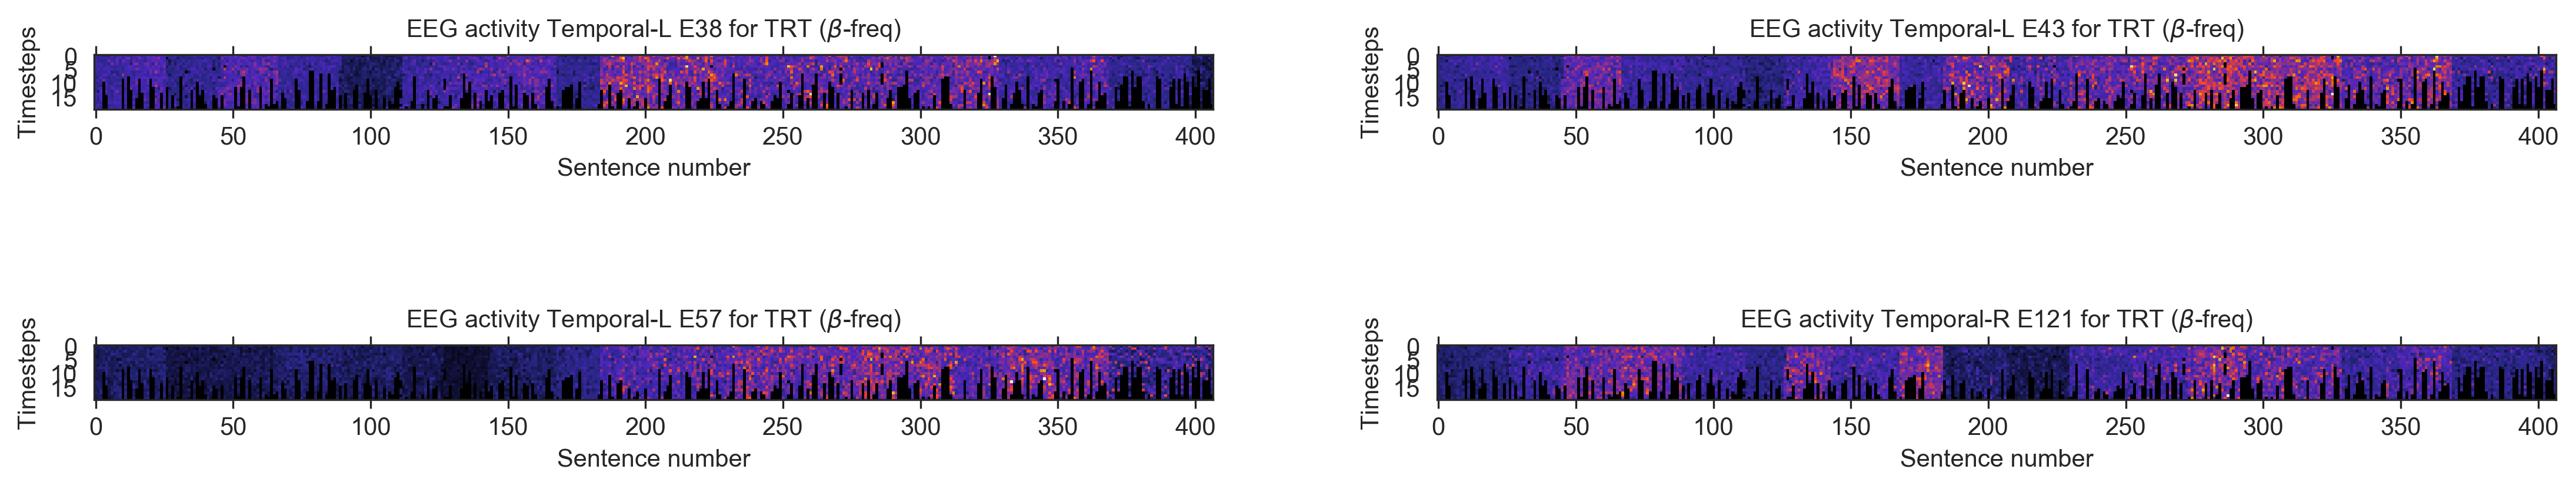

<Figure size 432x288 with 0 Axes>

In [38]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_beta_all[feat])).T, cmap = 'CMRmap')
        if (i % 2 == 0) or (i % 2 != 0 and j == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/beta_activity_temporal_heatmap_sbj1_task3')
plt.show()
plt.clf()

## $\gamma$-frequency domain

In [40]:
## Temporal Cortex ##
temporal_electrodes_gamma_all, temporal_indices_gamma_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                           eeg_locs_gamma_freqs, 
                                                                                           temporal_electrodes_gamma, 
                                                                                           k=20)
## Frontal & Parietal Cortex ##
frontoparietal_electrodes_gamma_all, frontoparietal_indices_gamma_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                                       eeg_locs_gamma_freqs, 
                                                                                                       frontoparietal_electrodes_gamma, 
                                                                                                       k=20)

In [ ]:
#kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

#feat = 0
#fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
#for i, row in enumerate(axes):
#    for j, col in enumerate(row):
#        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_gamma_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_gamma_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_gamma_all[feat]].mean()), (1.8, 0.6))
#        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_gamma_all[feat]].mean()), (1.8, 0.45))
#        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_features[i]), fontsize=10)
#        axes[i][j].set_ylabel(r'Density')
#        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
#        axes[i][j].set_xlim(0, 2.5)
#        feat += 1
#plt.savefig('plots/gamma_activity_temporal')
#plt.show()

### Density plots for activity in temporal cortex across all tasks and subjects

Observed difference of two means: -0.14
0 out of 1000 experiments had a difference of two means less than or equal to -0.14
The chance of getting a difference of two means less than or equal to -0.14 is 0.0000
Observed difference of two means: -0.13
0 out of 1000 experiments had a difference of two means less than or equal to -0.13
The chance of getting a difference of two means less than or equal to -0.13 is 0.0000
Observed difference of two means: -0.11
0 out of 1000 experiments had a difference of two means less than or equal to -0.11
The chance of getting a difference of two means less than or equal to -0.11 is 0.0000
Observed difference of two means: -0.02
0 out of 1000 experiments had a difference of two means less than or equal to -0.02
The chance of getting a difference of two means less than or equal to -0.02 is 0.0000


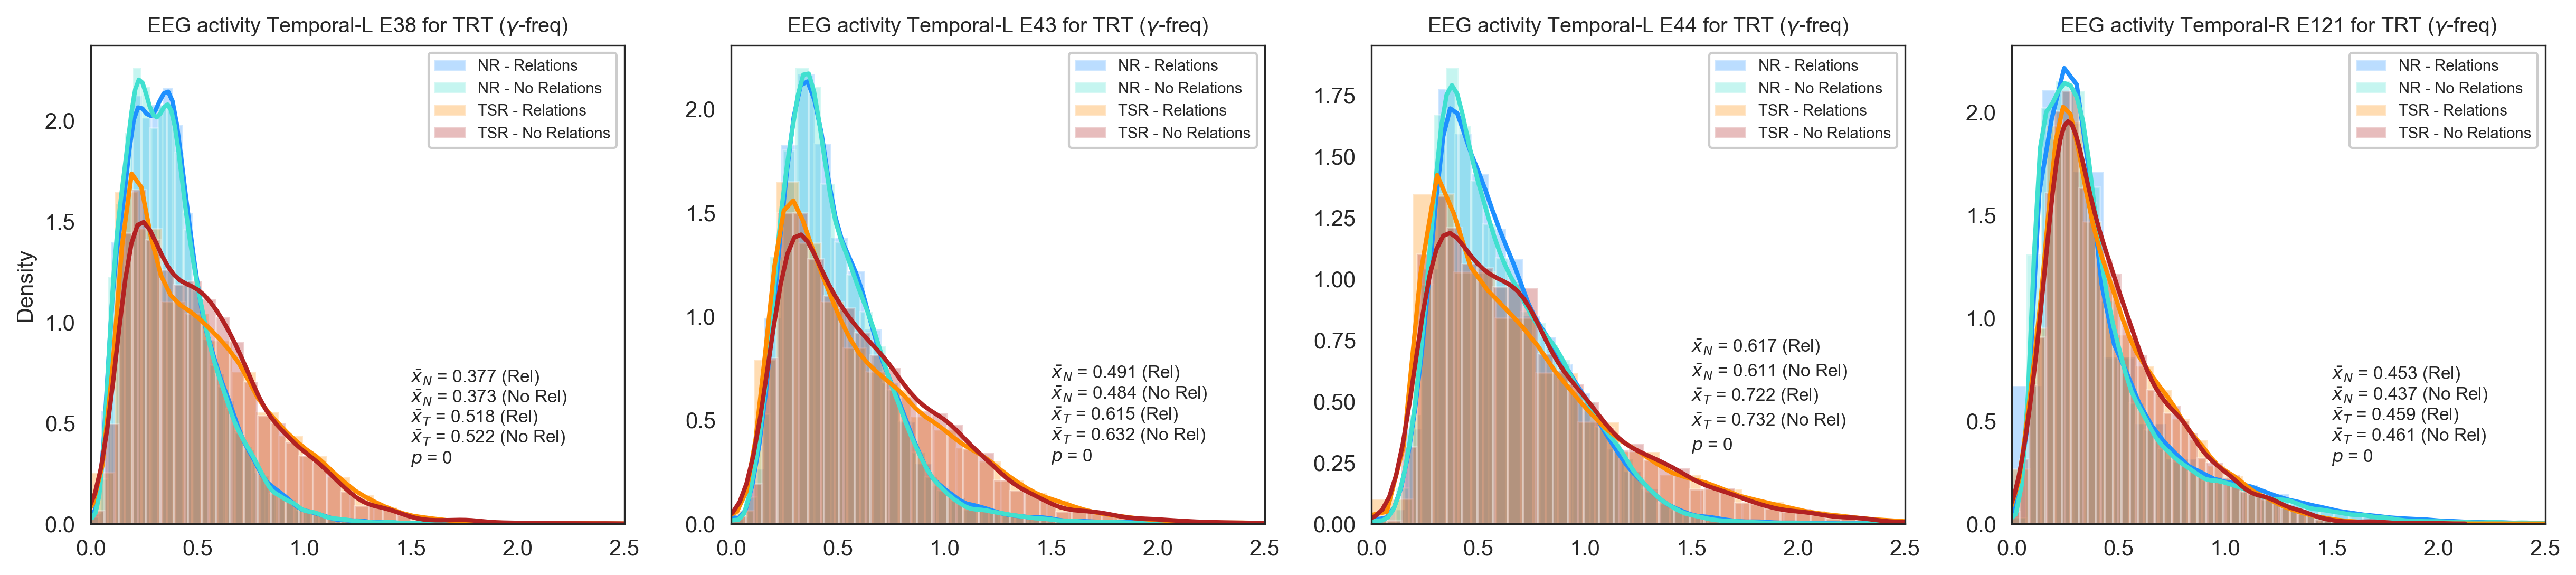

<Figure size 432x288 with 0 Axes>

In [48]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_gamma_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_gamma_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_gamma_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_gamma_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_gamma_all[feat]].mean()), (1.5, 0.7), fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_gamma_all[feat]].mean()), (1.5, 0.6), fontsize=8)      
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_gamma_all[feat]].mean()), (1.5, 0.5), fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_gamma_all[feat]].mean()), (1.5, 0.4), fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2[:, temporal_indices_gamma_all[feat]], eeg_feats_all_sbjs_task3[:, temporal_indices_gamma_all[feat]], nboot=1000)), (1.5, 0.3), fontsize=8)
    if i < 3:
        axes[i].set_title(r'EEG activity Temporal-L {} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_feature), fontsize=9.5)
    else:
        axes[i].set_title(r'EEG activity Temporal-R {} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_feature), fontsize=9.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in frontoparietal cortex across all tasks and subjects

Observed difference of two means: 0.02
0 out of 1000 experiments had a difference of two means greater than or equal to 0.02
The chance of getting a difference of two means greater than or equal to 0.02 is 0.0000
Observed difference of two means: -0.17
0 out of 1000 experiments had a difference of two means less than or equal to -0.17
The chance of getting a difference of two means less than or equal to -0.17 is 0.0000
Observed difference of two means: 0.00
54 out of 1000 experiments had a difference of two means greater than or equal to 0.00
The chance of getting a difference of two means greater than or equal to 0.00 is 0.0540


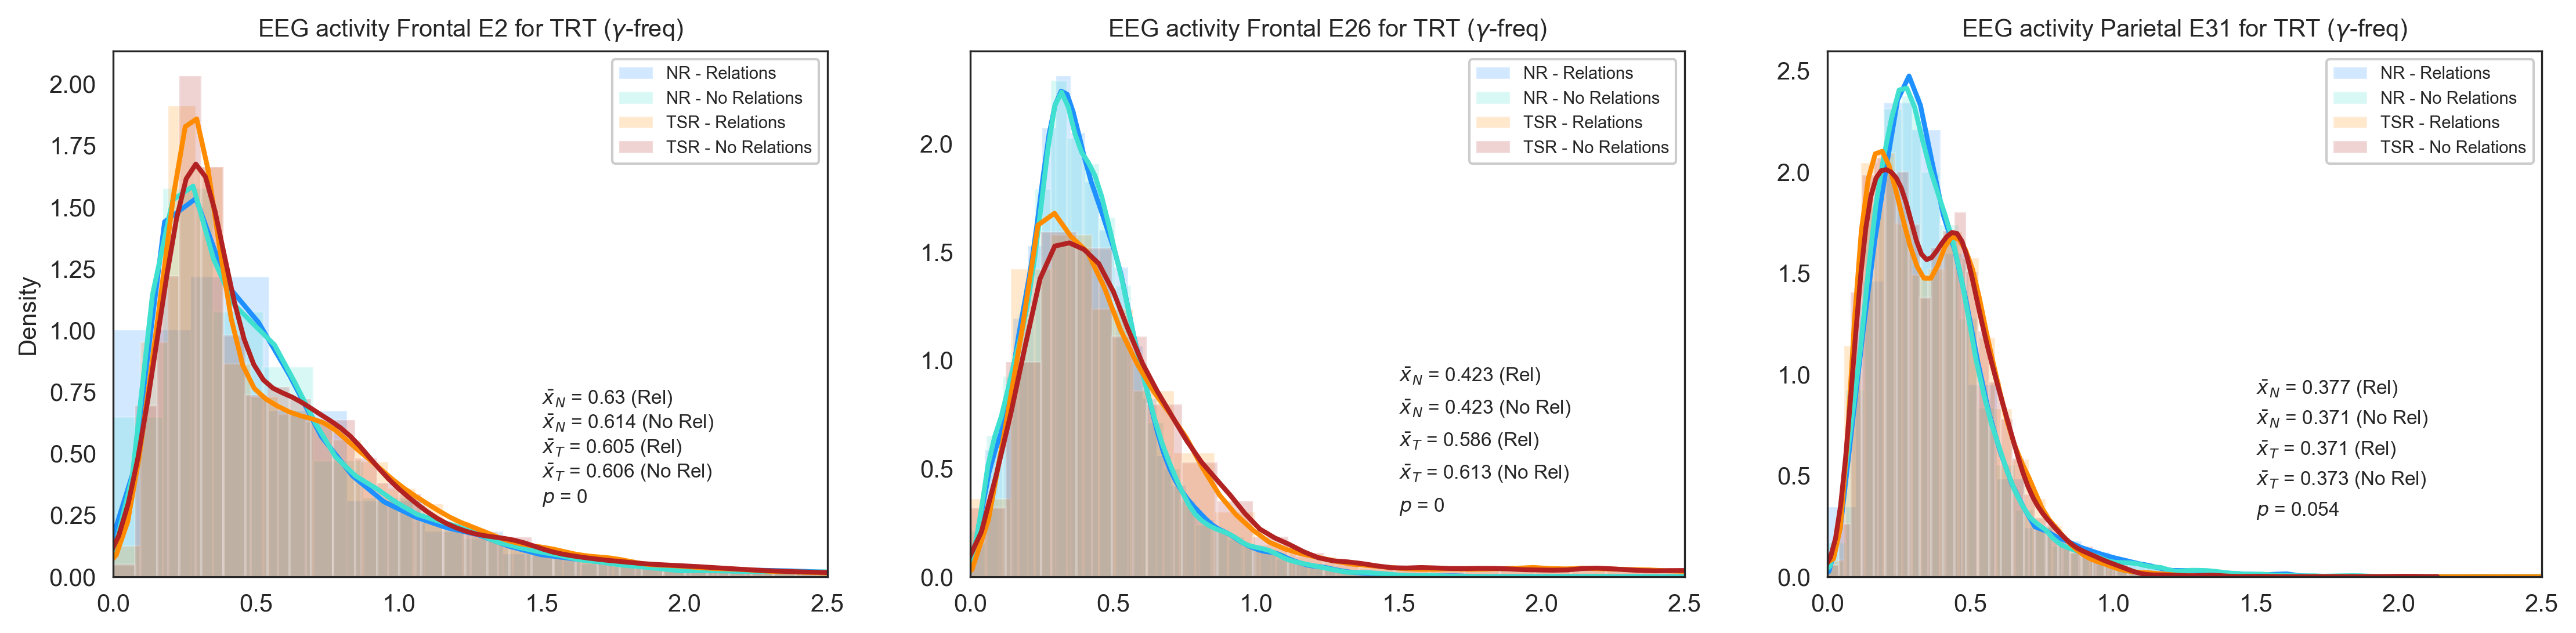

<Figure size 432x288 with 0 Axes>

In [50]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_gamma_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_gamma_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_gamma_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_gamma_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    pos = [(1.5, 0.9), (1.5, 0.75), (1.5, 0.6), (1.5, 0.45)] if i > 0 else [(1.5, 0.7), (1.5, 0.6), (1.5, 0.5), (1.5, 0.4)]
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_gamma_all[feat]].mean()), pos[0], fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_gamma_all[feat]].mean()), pos[1], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_gamma_all[feat]].mean()), pos[2], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_gamma_all[feat]].mean()), pos[3], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2[:, frontoparietal_indices_gamma_all[feat]], eeg_feats_all_sbjs_task3[:, frontoparietal_indices_gamma_all[feat]], nboot=1000)), (1.5, 0.3), fontsize=8)
    if i < 2:
        axes[i].set_title(r'EEG activity Frontal {} for {} ($\gamma$-freq)'.format(frontoparietal_electrodes_gamma_all[feat], et_feature), fontsize = 10)
    else:
        axes[i].set_title(r'EEG activity Parietal {} for {} ($\gamma$-freq)'.format(frontoparietal_electrodes_gamma_all[feat], et_feature), fontsize = 10)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Brain activity in the temporal cortex over time for single test subject(s) (Normal Reading)

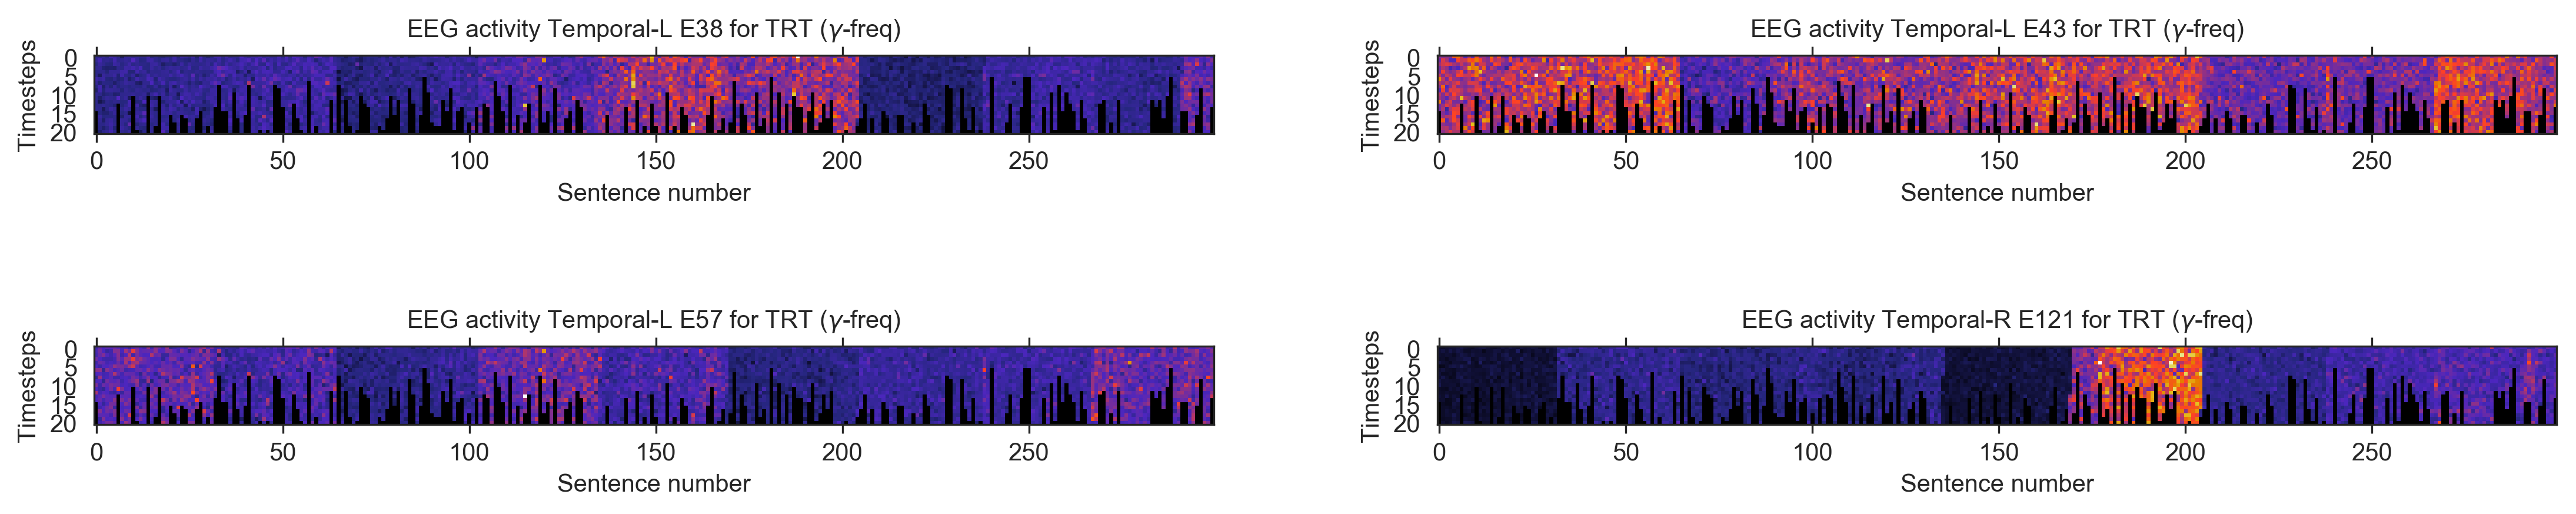

In [51]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_gamma_all[feat])).T, cmap='CMRmap')
        if (i % 2 == 0) or (i % 2 != 0 and j == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\gamma$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\gamma$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/gamma_activity_temporal_heatmap_sbj1_task2')
plt.show()

### Brain activity in the temporal cortex over time for single test subject(s) (Task Specific Reading)

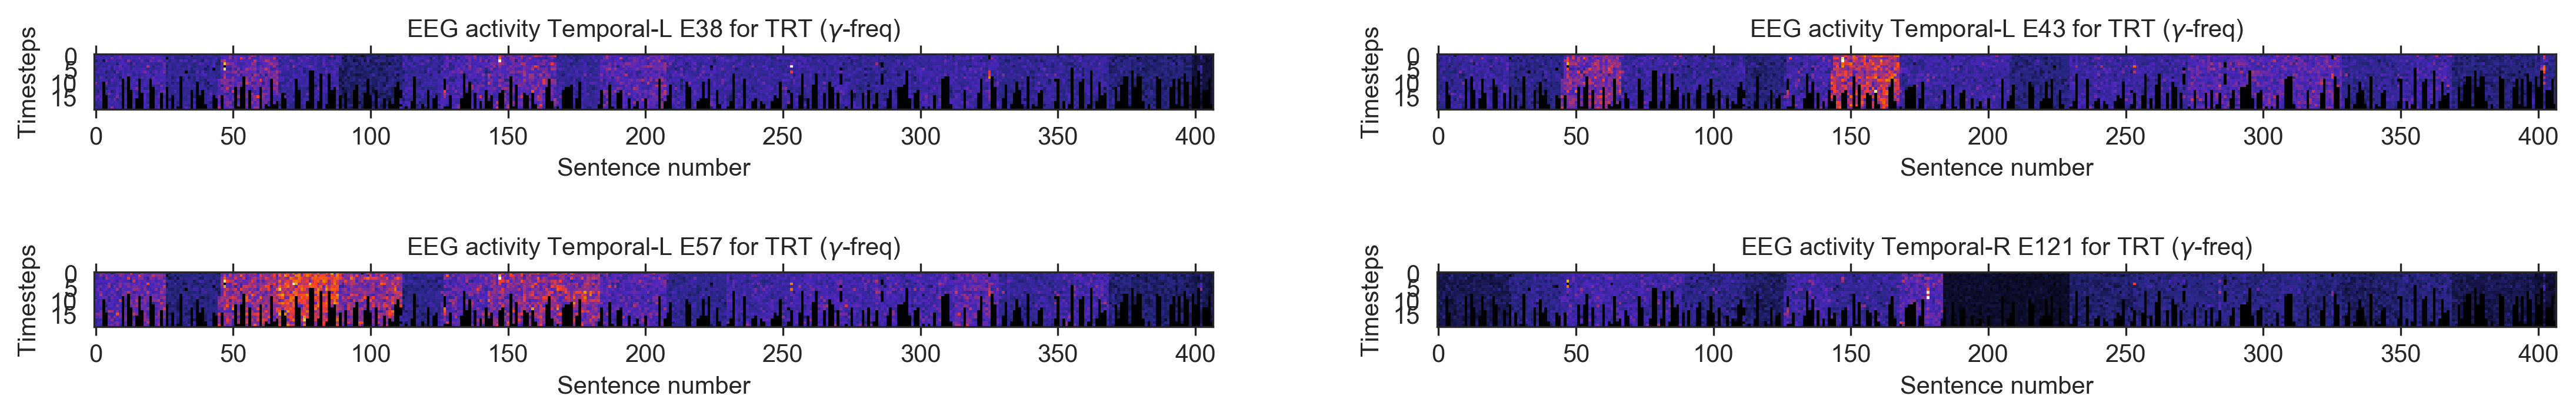

In [69]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 3), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_gamma_all[feat])).T, cmap='CMRmap')
        if (i % 2 == 0) or (i % 2 != 0 and j == 0):
            axes[i][j].set_title(r'EEG activity Temporal-L {} for {} ($\gamma$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        else:
            axes[i][j].set_title(r'EEG activity Temporal-R {} for {} ($\gamma$-freq)'.format(temporal_electrodes_beta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/gamma_activity_temporal_heatmap_sbj1_task3')
plt.show()

## $\theta$-frequency domain

In [53]:
## Temporal Cortex ##
temporal_electrodes_theta_all, temporal_indices_theta_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                           eeg_locs_theta_freqs, 
                                                                                           temporal_electrodes_theta, 
                                                                                           k=30)
## Frontal & Parietal Cortex ##
frontoparietal_electrodes_theta_all, frontoparietal_indices_theta_all = extract_electrodes_and_indices(eeg_electrodes_all,
                                                                                           eeg_locs_theta_freqs, 
                                                                                           frontoparietal_electrodes_theta, 
                                                                                           k=30)

In [ ]:
#kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

#feat = 0
#fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
#for i, row in enumerate(axes):
#    for j, col in enumerate(row):
#        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_theta_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_theta_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
#        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_theta_all[feat]].mean()), (1.8, 0.6))
#        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_theta_all[feat]].mean()), (1.8, 0.5))
#        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_features[i]), fontsize = 10)
#        axes[i][j].set_ylabel(r'Density')
#        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
#        axes[i][j].set_xlim(0, 2.5)
#        feat += 1
#plt.savefig('plots/theta_activity_temporal')
#plt.show()

### Density plots for activity in temporal cortex across all tasks and subjects

Observed difference of two means: -0.11
0 out of 1000 experiments had a difference of two means less than or equal to -0.11
The chance of getting a difference of two means less than or equal to -0.11 is 0.0000
Observed difference of two means: -0.09
0 out of 1000 experiments had a difference of two means less than or equal to -0.09
The chance of getting a difference of two means less than or equal to -0.09 is 0.0000
Observed difference of two means: -0.07
0 out of 1000 experiments had a difference of two means less than or equal to -0.07
The chance of getting a difference of two means less than or equal to -0.07 is 0.0000
Observed difference of two means: -0.08
0 out of 1000 experiments had a difference of two means less than or equal to -0.08
The chance of getting a difference of two means less than or equal to -0.08 is 0.0000
Observed difference of two means: -0.01
0 out of 1000 experiments had a difference of two means less than or equal to -0.01
The chance of getting a difference o

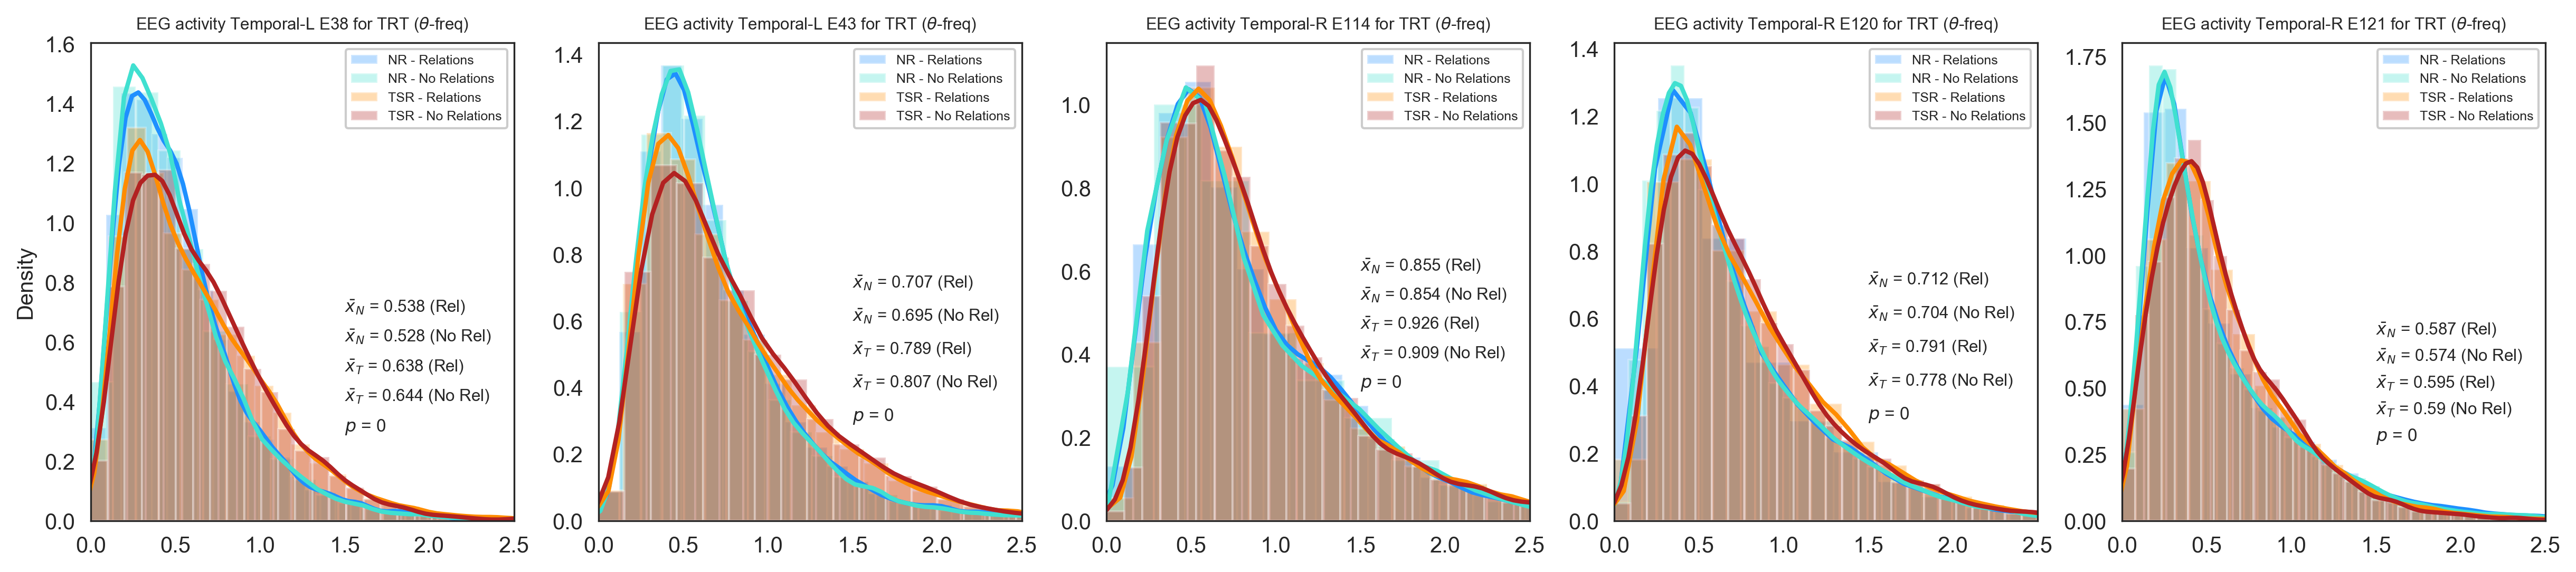

<Figure size 432x288 with 0 Axes>

In [59]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(1, 5, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_theta_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_theta_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_theta_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_theta_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    pos = [(1.5, 0.6), (1.5, 0.53), (1.5, 0.46), (1.5, 0.39)] if i == 2 else [(1.5, 0.7), (1.5, 0.6), (1.5, 0.5), (1.5, 0.4)]
    xy_pos_text = (1.5, 0.32) if i == 2 else (1.5, 0.3)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, temporal_indices_theta_all[feat]].mean()), pos[0], fontsize=7.5)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, temporal_indices_theta_all[feat]].mean()), pos[1], fontsize=7.5)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, temporal_indices_theta_all[feat]].mean()), pos[2], fontsize=7.5)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, temporal_indices_theta_all[feat]].mean()), pos[3], fontsize=7.5)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2[:, temporal_indices_theta_all[feat]], eeg_feats_all_sbjs_task3[:, temporal_indices_theta_all[feat]], nboot=1000)), xy_pos_text, fontsize=8)
    if i < 2:
        axes[i].set_title(r'EEG activity Temporal-L {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_feature), fontsize=7.5)
    else:
        axes[i].set_title(r'EEG activity Temporal-R {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_feature), fontsize=7.5)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':6})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/alpha_activity_temporal')
plt.show()
plt.clf()

### Density plots for activity in frontoparietal cortex across all tasks and subjects

Observed difference of two means: 0.15
0 out of 1000 experiments had a difference of two means greater than or equal to 0.15
The chance of getting a difference of two means greater than or equal to 0.15 is 0.0000
Observed difference of two means: 0.14
0 out of 1000 experiments had a difference of two means greater than or equal to 0.14
The chance of getting a difference of two means greater than or equal to 0.14 is 0.0000
Observed difference of two means: 0.23
0 out of 1000 experiments had a difference of two means greater than or equal to 0.23
The chance of getting a difference of two means greater than or equal to 0.23 is 0.0000


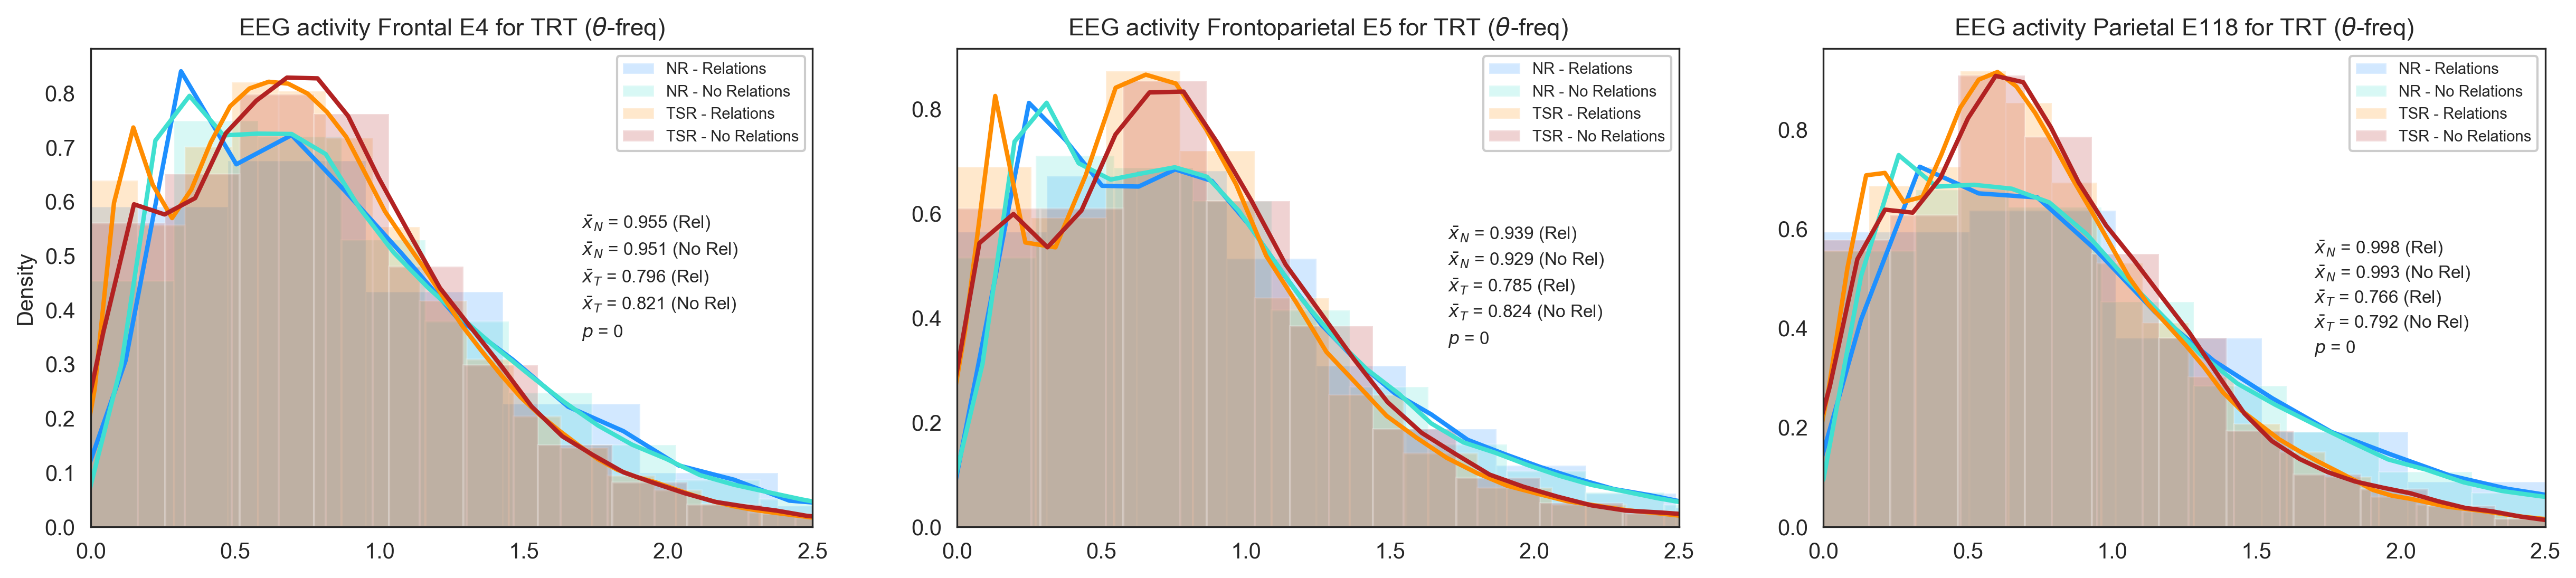

<Figure size 432x288 with 0 Axes>

In [60]:
kwargs = dict(hist_kws={'alpha':.2}, kde_kws={'linewidth':2})

pos = [(1.7, 0.55), (1.7, 0.5), (1.7, 0.45), (1.7, 0.40)]
xy_pos_text = (1.7, 0.35)
feat = 0
fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=300)
for i, _ in enumerate(axes):
    sns.distplot(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_theta_all[feat]], color="dodgerblue", label="NR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_theta_all[feat]], color="turquoise", label="NR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_theta_all[feat]], color="darkorange", label="TSR - Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    sns.distplot(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_theta_all[feat]], color="firebrick", label="TSR - No Relations", kde=True, norm_hist=True, ax=axes[i], **kwargs)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (Rel) '.format(eeg_feats_all_sbjs_task2_relations[:, frontoparietal_indices_theta_all[feat]].mean()), pos[0], fontsize=8)
    axes[i].annotate(r'$\bar x_N$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task2_no_relations[:, frontoparietal_indices_theta_all[feat]].mean()), pos[1], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (Rel)'.format(eeg_feats_all_sbjs_task3_relations[:, frontoparietal_indices_theta_all[feat]].mean()), pos[2], fontsize=8)
    axes[i].annotate(r'$\bar x_T$ = {:.3g} (No Rel)'.format(eeg_feats_all_sbjs_task3_no_relations[:, frontoparietal_indices_theta_all[feat]].mean()), pos[3], fontsize=8)
    axes[i].annotate(r'$p$ = {:.3g}'.format(bootpv(eeg_feats_all_sbjs_task2[:, frontoparietal_indices_theta_all[feat]], eeg_feats_all_sbjs_task3[:, frontoparietal_indices_theta_all[feat]], nboot=1000)), xy_pos_text, fontsize=8)
    if i == 0:
        axes[i].set_title(r'EEG activity Frontal {} for {} ($\theta$-freq)'.format(frontoparietal_electrodes_theta_all[feat], et_feature), fontsize = 11)
    elif i == 1:
        axes[i].set_title(r'EEG activity Frontoparietal {} for {} ($\theta$-freq)'.format(frontoparietal_electrodes_theta_all[feat], et_feature), fontsize = 11)
    else:
        axes[i].set_title(r'EEG activity Parietal {} for {} ($\theta$-freq)'.format(frontoparietal_electrodes_theta_all[feat], et_feature), fontsize = 11)
    if i == 0: axes[i].set_ylabel(r'Density')
    axes[i].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
    axes[i].set_xlim(0, 2.5)
    feat += 1
#plt.savefig('plots/theta_activity_frontoparietal')
plt.show()
plt.clf()

### Brain activity in the temporal cortex over time for single test subject(s) (Normal Reading)

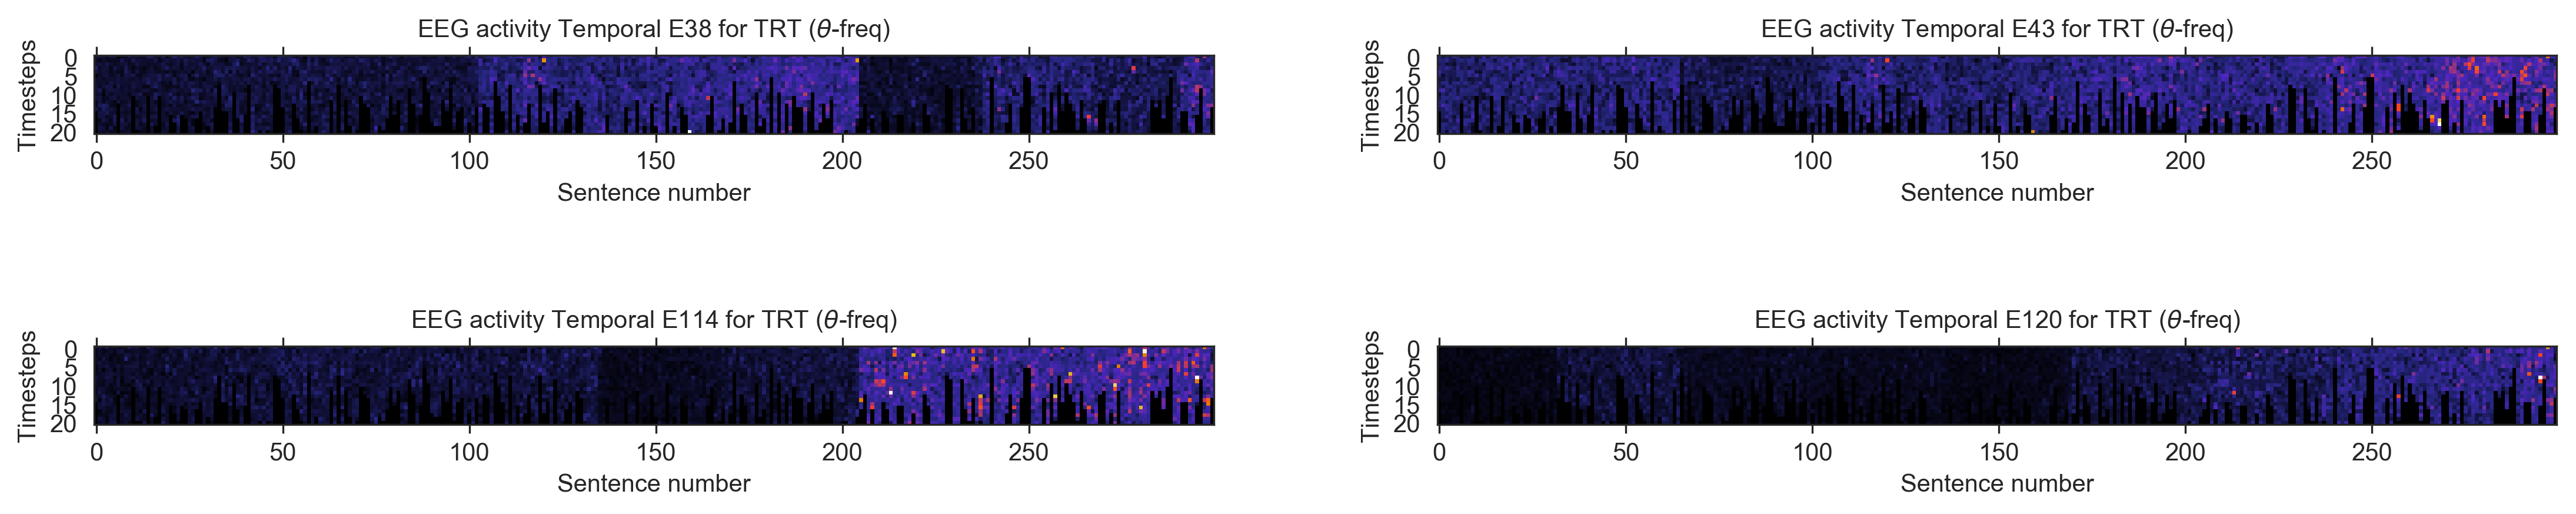

In [61]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 4), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_theta_all[feat])).T, cmap = 'CMRmap')
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/theta_activity_temporal_heatmap_sbj1_task2')
plt.show()

### Brain activity in the temporal cortex over time for single test subject(s) (Task Specific Reading)

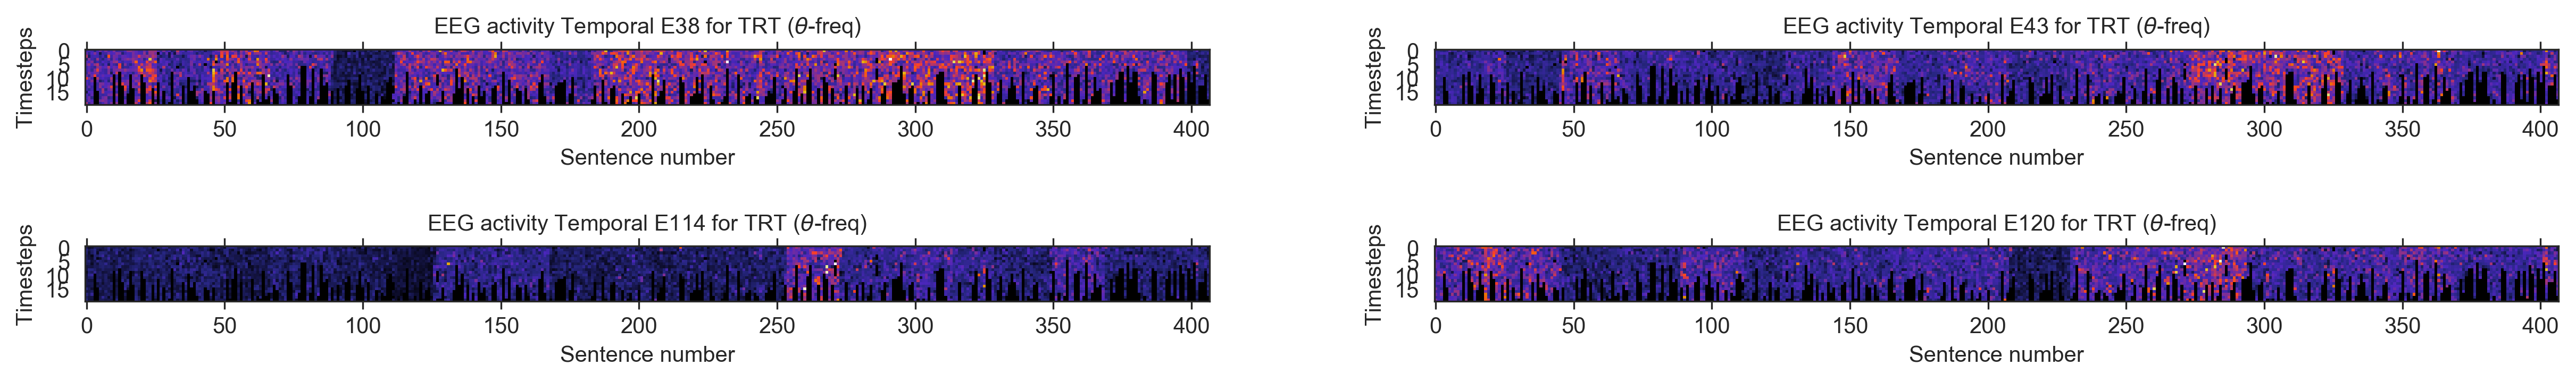

In [68]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(2, 2, figsize=(20, 3), dpi=300)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_theta_all[feat])).T, cmap='CMRmap')
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_feature), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/theta_activity_temporal_heatmap_sbj1_task3')
plt.show()